In [1]:
!nvidia-smi

Fri Mar  1 16:19:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   36C    P8              20W / 215W |    306MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('../../')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold2/'

cuda


In [6]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [7]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [8]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [9]:
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13mfcc_sm.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')

name: M13mfcc
description: FirConv with fftconv
mfcc:
  n_mfcc: 40
  n_fft: 512
  hop_length: 128
  n_mels: 64
  sample_rate: 16000
pooling: mean
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)
total parameters: 77394


In [10]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [11]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [12]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                          | 0.00411522633744856/10 [00:00<19:00, 114.09s/it]

Train Epoch: 1 [0/11685 (0%)]	Loss: 1.109148
Mem before-during-after: 389120 9054720 18361856


  1%|▉                                                                                                          | 0.08641975308641978/10 [00:07<13:31, 81.88s/it]

Train Epoch: 1 [1280/11685 (11%)]	Loss: 0.426495
Mem before-during-after: 18361856 18506752 18361856


  2%|█▊                                                                                                         | 0.16872427983539084/10 [00:13<12:49, 78.23s/it]

Train Epoch: 1 [2560/11685 (22%)]	Loss: 0.651195
Mem before-during-after: 18361856 18506752 18361856


  3%|██▋                                                                                                        | 0.25102880658436166/10 [00:20<12:54, 79.46s/it]

Train Epoch: 1 [3840/11685 (33%)]	Loss: 0.083990
Mem before-during-after: 18361856 18506752 18361856


  3%|███▌                                                                                                        | 0.3333333333333325/10 [00:27<12:55, 80.27s/it]

Train Epoch: 1 [5120/11685 (44%)]	Loss: 0.747800
Mem before-during-after: 18361856 18506752 18361856


  4%|████▍                                                                                                       | 0.4156378600823033/10 [00:34<13:29, 84.42s/it]

Train Epoch: 1 [6400/11685 (55%)]	Loss: 0.552396
Mem before-during-after: 18361856 18506752 18361856


  5%|█████▍                                                                                                      | 0.4979423868312741/10 [00:41<13:21, 84.34s/it]

Train Epoch: 1 [7680/11685 (66%)]	Loss: 1.125171
Mem before-during-after: 18361856 18506752 18361856


  6%|██████▎                                                                                                      | 0.580246913580247/10 [00:47<12:43, 81.06s/it]

Train Epoch: 1 [8960/11685 (77%)]	Loss: 0.489151
Mem before-during-after: 18361856 18506752 18361856


  7%|███████▏                                                                                                    | 0.6625514403292201/10 [00:54<13:01, 83.74s/it]

Train Epoch: 1 [10240/11685 (88%)]	Loss: 1.256172
Mem before-during-after: 18361856 18506752 18361856


  7%|████████                                                                                                    | 0.7448559670781931/10 [01:01<12:03, 78.12s/it]

Train Epoch: 1 [11520/11685 (99%)]	Loss: 0.483744
Mem before-during-after: 18361856 18506752 18361856


 10%|██████████▊                                                                                                 | 1.0020576131687338/10 [01:21<11:38, 77.68s/it]


Test Epoch: 1	Accuracy: 3037/3872 (78%)

Train Epoch: 2 [0/11685 (0%)]	Loss: 0.013150
Mem before-during-after: 18360832 18506752 18361856


 11%|███████████▋                                                                                                | 1.0864197530864266/10 [01:27<11:29, 77.35s/it]

Train Epoch: 2 [1280/11685 (11%)]	Loss: 0.031592
Mem before-during-after: 18361856 18506752 18361856


 12%|████████████▌                                                                                               | 1.1687242798353952/10 [01:34<11:37, 78.93s/it]

Train Epoch: 2 [2560/11685 (22%)]	Loss: 0.695553
Mem before-during-after: 18361856 18506752 18361856


 13%|█████████████▌                                                                                              | 1.2510288065843638/10 [01:40<11:19, 77.71s/it]

Train Epoch: 2 [3840/11685 (33%)]	Loss: 0.104719
Mem before-during-after: 18361856 18506752 18361856


 13%|██████████████▍                                                                                             | 1.3333333333333324/10 [01:47<11:54, 82.47s/it]

Train Epoch: 2 [5120/11685 (44%)]	Loss: 1.221028
Mem before-during-after: 18361856 18506752 18361856


 14%|███████████████▍                                                                                             | 1.415637860082301/10 [01:53<10:53, 76.09s/it]

Train Epoch: 2 [6400/11685 (55%)]	Loss: 0.490748
Mem before-during-after: 18361856 18506752 18361856


 15%|████████████████▏                                                                                           | 1.4979423868312696/10 [01:59<11:20, 80.04s/it]

Train Epoch: 2 [7680/11685 (66%)]	Loss: 1.361218
Mem before-during-after: 18361856 18506752 18361856


 16%|█████████████████                                                                                           | 1.5802469135802382/10 [02:06<10:54, 77.76s/it]

Train Epoch: 2 [8960/11685 (77%)]	Loss: 0.258849
Mem before-during-after: 18361856 18506752 18361856


 17%|█████████████████▉                                                                                          | 1.6625514403292068/10 [02:12<10:38, 76.59s/it]

Train Epoch: 2 [10240/11685 (88%)]	Loss: 1.395471
Mem before-during-after: 18361856 18506752 18361856


 17%|██████████████████▊                                                                                         | 1.7448559670781754/10 [02:19<10:38, 77.39s/it]

Train Epoch: 2 [11520/11685 (99%)]	Loss: 0.881339
Mem before-during-after: 18361856 18506752 18361856


 20%|█████████████████████▌                                                                                      | 2.0020576131687022/10 [02:39<10:22, 77.84s/it]


Test Epoch: 2	Accuracy: 3265/3872 (84%)

Train Epoch: 3 [0/11685 (0%)]	Loss: 0.005499
Mem before-during-after: 18360832 18506752 18361856


 21%|██████████████████████▋                                                                                      | 2.086419753086404/10 [02:45<10:17, 78.08s/it]

Train Epoch: 3 [1280/11685 (11%)]	Loss: 0.010536
Mem before-during-after: 18361856 18506752 18361856


 22%|███████████████████████▍                                                                                    | 2.1687242798353816/10 [02:52<10:06, 77.45s/it]

Train Epoch: 3 [2560/11685 (22%)]	Loss: 0.259967
Mem before-during-after: 18361856 18506752 18361856


 23%|████████████████████████▌                                                                                    | 2.251028806584359/10 [02:58<10:16, 79.61s/it]

Train Epoch: 3 [3840/11685 (33%)]	Loss: 0.023941
Mem before-during-after: 18361856 18506752 18361856


 23%|█████████████████████████▏                                                                                  | 2.3333333333333366/10 [03:04<09:52, 77.25s/it]

Train Epoch: 3 [5120/11685 (44%)]	Loss: 1.131560
Mem before-during-after: 18361856 18506752 18361856


 24%|██████████████████████████▎                                                                                  | 2.415637860082314/10 [03:11<09:45, 77.15s/it]

Train Epoch: 3 [6400/11685 (55%)]	Loss: 0.418296
Mem before-during-after: 18361856 18506752 18361856


 25%|██████████████████████████▉                                                                                 | 2.4979423868312916/10 [03:17<09:52, 78.97s/it]

Train Epoch: 3 [7680/11685 (66%)]	Loss: 1.207029
Mem before-during-after: 18361856 18506752 18361856


 26%|████████████████████████████                                                                                 | 2.580246913580269/10 [03:24<09:30, 76.87s/it]

Train Epoch: 3 [8960/11685 (77%)]	Loss: 0.335827
Mem before-during-after: 18361856 18506752 18361856


 27%|████████████████████████████▊                                                                               | 2.6625514403292465/10 [03:30<09:55, 81.16s/it]

Train Epoch: 3 [10240/11685 (88%)]	Loss: 1.889952
Mem before-during-after: 18361856 18506752 18361856


 27%|█████████████████████████████▉                                                                               | 2.744855967078224/10 [03:36<09:21, 77.43s/it]

Train Epoch: 3 [11520/11685 (99%)]	Loss: 1.058346
Mem before-during-after: 18361856 18506752 18361856


 30%|████████████████████████████████▍                                                                           | 3.0020576131687786/10 [03:56<09:08, 78.39s/it]


Test Epoch: 3	Accuracy: 3240/3872 (83%)

Train Epoch: 4 [0/11685 (0%)]	Loss: 0.001388
Mem before-during-after: 18360832 18506752 18361856


 31%|█████████████████████████████████▎                                                                          | 3.0864197530864805/10 [04:03<08:52, 76.98s/it]

Train Epoch: 4 [1280/11685 (11%)]	Loss: 0.002355
Mem before-during-after: 18361856 18506752 18361856


 32%|██████████████████████████████████▌                                                                          | 3.168724279835458/10 [04:09<09:04, 79.71s/it]

Train Epoch: 4 [2560/11685 (22%)]	Loss: 0.219510
Mem before-during-after: 18361856 18506752 18361856


 33%|███████████████████████████████████                                                                         | 3.2510288065844355/10 [04:16<08:45, 77.87s/it]

Train Epoch: 4 [3840/11685 (33%)]	Loss: 0.049962
Mem before-during-after: 18361856 18506752 18361856


 33%|████████████████████████████████████▎                                                                        | 3.333333333333413/10 [04:22<08:24, 75.70s/it]

Train Epoch: 4 [5120/11685 (44%)]	Loss: 1.568180
Mem before-during-after: 18361856 18506752 18361856


 34%|████████████████████████████████████▉                                                                       | 3.4156378600823905/10 [04:28<08:29, 77.39s/it]

Train Epoch: 4 [6400/11685 (55%)]	Loss: 0.339496
Mem before-during-after: 18361856 18506752 18361856


 35%|██████████████████████████████████████▏                                                                      | 3.497942386831368/10 [04:35<08:20, 76.91s/it]

Train Epoch: 4 [7680/11685 (66%)]	Loss: 1.308918
Mem before-during-after: 18361856 18506752 18361856


 36%|██████████████████████████████████████▋                                                                     | 3.5802469135803454/10 [04:41<08:17, 77.53s/it]

Train Epoch: 4 [8960/11685 (77%)]	Loss: 0.367350
Mem before-during-after: 18361856 18506752 18361856


 37%|███████████████████████████████████████▉                                                                     | 3.662551440329323/10 [04:48<08:13, 77.90s/it]

Train Epoch: 4 [10240/11685 (88%)]	Loss: 1.590002
Mem before-during-after: 18361856 18506752 18361856


 37%|████████████████████████████████████████▍                                                                   | 3.7448559670783004/10 [04:54<08:08, 78.06s/it]

Train Epoch: 4 [11520/11685 (99%)]	Loss: 0.927782
Mem before-during-after: 18361856 18506752 18361856


 40%|███████████████████████████████████████████▌                                                                 | 4.002057613168855/10 [05:14<07:40, 76.73s/it]


Test Epoch: 4	Accuracy: 3279/3872 (84%)

Train Epoch: 5 [0/11685 (0%)]	Loss: 0.001169
Mem before-during-after: 18360832 18506752 18361856


 41%|████████████████████████████████████████████▌                                                                | 4.086419753086557/10 [05:20<07:43, 78.45s/it]

Train Epoch: 5 [1280/11685 (11%)]	Loss: 0.002293
Mem before-during-after: 18361856 18506752 18361856


 42%|█████████████████████████████████████████████▍                                                               | 4.168724279835534/10 [05:27<07:26, 76.63s/it]

Train Epoch: 5 [2560/11685 (22%)]	Loss: 0.358448
Mem before-during-after: 18361856 18506752 18361856


 43%|██████████████████████████████████████████████▎                                                              | 4.251028806584512/10 [05:33<07:27, 77.79s/it]

Train Epoch: 5 [3840/11685 (33%)]	Loss: 0.055918
Mem before-during-after: 18361856 18506752 18361856


 43%|███████████████████████████████████████████████▏                                                             | 4.333333333333489/10 [05:40<07:39, 81.17s/it]

Train Epoch: 5 [5120/11685 (44%)]	Loss: 1.127011
Mem before-during-after: 18361856 18506752 18361856


 44%|████████████████████████████████████████████████▏                                                            | 4.415637860082467/10 [05:46<06:58, 75.00s/it]

Train Epoch: 5 [6400/11685 (55%)]	Loss: 0.263310
Mem before-during-after: 18361856 18506752 18361856


 45%|█████████████████████████████████████████████████                                                            | 4.497942386831444/10 [05:52<07:16, 79.31s/it]

Train Epoch: 5 [7680/11685 (66%)]	Loss: 1.109154
Mem before-during-after: 18361856 18506752 18361856


 46%|█████████████████████████████████████████████████▉                                                           | 4.580246913580422/10 [05:59<07:05, 78.46s/it]

Train Epoch: 5 [8960/11685 (77%)]	Loss: 0.389109
Mem before-during-after: 18361856 18506752 18361856


 47%|██████████████████████████████████████████████████▊                                                          | 4.662551440329399/10 [06:05<07:14, 81.37s/it]

Train Epoch: 5 [10240/11685 (88%)]	Loss: 1.711105
Mem before-during-after: 18361856 18506752 18361856


 47%|███████████████████████████████████████████████████▋                                                         | 4.744855967078377/10 [06:12<06:49, 77.89s/it]

Train Epoch: 5 [11520/11685 (99%)]	Loss: 0.629131
Mem before-during-after: 18361856 18506752 18361856


 50%|██████████████████████████████████████████████████████▌                                                      | 5.002057613168931/10 [06:31<06:18, 75.83s/it]


Test Epoch: 5	Accuracy: 3311/3872 (85%)

Train Epoch: 6 [0/11685 (0%)]	Loss: 0.008751
Mem before-during-after: 18360832 18506752 18361856


 51%|███████████████████████████████████████████████████████▍                                                     | 5.086419753086633/10 [06:38<06:47, 82.98s/it]

Train Epoch: 6 [1280/11685 (11%)]	Loss: 0.002441
Mem before-during-after: 18361856 18506752 18361856


 52%|████████████████████████████████████████████████████████▎                                                    | 5.168724279835611/10 [06:44<06:19, 78.59s/it]

Train Epoch: 6 [2560/11685 (22%)]	Loss: 0.246457
Mem before-during-after: 18361856 18506752 18361856


 53%|█████████████████████████████████████████████████████████▏                                                   | 5.251028806584588/10 [06:51<06:09, 77.90s/it]

Train Epoch: 6 [3840/11685 (33%)]	Loss: 0.008744
Mem before-during-after: 18361856 18506752 18361856


 53%|██████████████████████████████████████████████████████████▏                                                  | 5.333333333333566/10 [06:57<06:01, 77.38s/it]

Train Epoch: 6 [5120/11685 (44%)]	Loss: 1.112559
Mem before-during-after: 18361856 18506752 18361856


 54%|███████████████████████████████████████████████████████████                                                  | 5.415637860082543/10 [07:04<05:54, 77.23s/it]

Train Epoch: 6 [6400/11685 (55%)]	Loss: 0.115639
Mem before-during-after: 18361856 18506752 18361856


 55%|███████████████████████████████████████████████████████████▉                                                 | 5.497942386831521/10 [07:10<05:55, 79.03s/it]

Train Epoch: 6 [7680/11685 (66%)]	Loss: 1.454075
Mem before-during-after: 18361856 18506752 18361856


 56%|████████████████████████████████████████████████████████████▊                                                | 5.580246913580498/10 [07:16<05:37, 76.46s/it]

Train Epoch: 6 [8960/11685 (77%)]	Loss: 0.277392
Mem before-during-after: 18361856 18506752 18361856


 57%|█████████████████████████████████████████████████████████████▋                                               | 5.662551440329476/10 [07:23<05:39, 78.28s/it]

Train Epoch: 6 [10240/11685 (88%)]	Loss: 2.770894
Mem before-during-after: 18361856 18506752 18361856


 57%|██████████████████████████████████████████████████████████████▌                                              | 5.744855967078453/10 [07:29<05:26, 76.78s/it]

Train Epoch: 6 [11520/11685 (99%)]	Loss: 0.949239
Mem before-during-after: 18361856 18506752 18361856


 60%|█████████████████████████████████████████████████████████████████▍                                           | 6.002057613169008/10 [07:49<05:02, 75.56s/it]


Test Epoch: 6	Accuracy: 3337/3872 (86%)

Train Epoch: 7 [0/11685 (0%)]	Loss: 0.003556
Mem before-during-after: 18360832 18506752 18361856


 61%|██████████████████████████████████████████████████████████████████▉                                           | 6.08641975308671/10 [07:56<05:07, 78.61s/it]

Train Epoch: 7 [1280/11685 (11%)]	Loss: 0.002477
Mem before-during-after: 18361856 18506752 18361856


 62%|███████████████████████████████████████████████████████████████████▏                                         | 6.168724279835687/10 [08:02<05:16, 82.65s/it]

Train Epoch: 7 [2560/11685 (22%)]	Loss: 0.295081
Mem before-during-after: 18361856 18506752 18361856


 63%|████████████████████████████████████████████████████████████████████▏                                        | 6.251028806584665/10 [08:08<04:59, 79.77s/it]

Train Epoch: 7 [3840/11685 (33%)]	Loss: 0.012306
Mem before-during-after: 18361856 18506752 18361856


 63%|█████████████████████████████████████████████████████████████████████                                        | 6.333333333333642/10 [08:15<04:39, 76.16s/it]

Train Epoch: 7 [5120/11685 (44%)]	Loss: 1.817267
Mem before-during-after: 18361856 18506752 18361856


 64%|██████████████████████████████████████████████████████████████████████▌                                       | 6.41563786008262/10 [08:21<04:37, 77.37s/it]

Train Epoch: 7 [6400/11685 (55%)]	Loss: 0.145220
Mem before-during-after: 18361856 18506752 18361856


 65%|██████████████████████████████████████████████████████████████████████▊                                      | 6.497942386831597/10 [08:27<04:29, 77.04s/it]

Train Epoch: 7 [7680/11685 (66%)]	Loss: 1.347342
Mem before-during-after: 18361856 18506752 18361856


 66%|███████████████████████████████████████████████████████████████████████▋                                     | 6.580246913580575/10 [08:34<04:23, 76.91s/it]

Train Epoch: 7 [8960/11685 (77%)]	Loss: 0.302301
Mem before-during-after: 18361856 18506752 18361856


 67%|████████████████████████████████████████████████████████████████████████▌                                    | 6.662551440329552/10 [08:40<04:19, 77.82s/it]

Train Epoch: 7 [10240/11685 (88%)]	Loss: 1.630148
Mem before-during-after: 18361856 18506752 18361856


 67%|████████████████████████████████████████████████████████████████████████▊                                   | 6.7448559670785295/10 [08:47<04:06, 75.70s/it]

Train Epoch: 7 [11520/11685 (99%)]	Loss: 0.706765
Mem before-during-after: 18361856 18506752 18361856


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 7.002057613169084/10 [09:06<03:54, 78.30s/it]


Test Epoch: 7	Accuracy: 3336/3872 (86%)

Train Epoch: 8 [0/11685 (0%)]	Loss: 0.004809
Mem before-during-after: 18360832 18506752 18361856


 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 7.086419753086786/10 [09:13<03:47, 78.23s/it]

Train Epoch: 8 [1280/11685 (11%)]	Loss: 0.004288
Mem before-during-after: 18361856 18506752 18361856


 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 7.1687242798357635/10 [09:19<03:43, 78.82s/it]

Train Epoch: 8 [2560/11685 (22%)]	Loss: 0.212476
Mem before-during-after: 18361856 18506752 18361856


 73%|███████████████████████████████████████████████████████████████████████████████                              | 7.251028806584741/10 [09:26<03:28, 76.00s/it]

Train Epoch: 8 [3840/11685 (33%)]	Loss: 0.025103
Mem before-during-after: 18361856 18506752 18361856


 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 7.3333333333337185/10 [09:32<03:29, 78.49s/it]

Train Epoch: 8 [5120/11685 (44%)]	Loss: 1.867837
Mem before-during-after: 18361856 18506752 18361856


 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 7.415637860082696/10 [09:39<03:22, 78.24s/it]

Train Epoch: 8 [6400/11685 (55%)]	Loss: 0.161805
Mem before-during-after: 18361856 18506752 18361856


 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 7.4979423868316735/10 [09:45<03:28, 83.36s/it]

Train Epoch: 8 [7680/11685 (66%)]	Loss: 0.999842
Mem before-during-after: 18361856 18506752 18361856


 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 7.580246913580651/10 [09:51<03:05, 76.80s/it]

Train Epoch: 8 [8960/11685 (77%)]	Loss: 0.401749
Mem before-during-after: 18361856 18506752 18361856


 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 7.662551440329628/10 [09:58<02:57, 76.11s/it]

Train Epoch: 8 [10240/11685 (88%)]	Loss: 2.290889
Mem before-during-after: 18361856 18506752 18361856


 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 7.744855967078606/10 [10:04<02:55, 78.00s/it]

Train Epoch: 8 [11520/11685 (99%)]	Loss: 0.672731
Mem before-during-after: 18361856 18506752 18361856


 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 8.002057613169159/10 [10:24<02:44, 82.27s/it]


Test Epoch: 8	Accuracy: 3281/3872 (84%)

Train Epoch: 9 [0/11685 (0%)]	Loss: 0.004999
Mem before-during-after: 18360832 18506752 18361856


 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 8.086419753086824/10 [10:30<02:32, 79.61s/it]

Train Epoch: 9 [1280/11685 (11%)]	Loss: 0.000376
Mem before-during-after: 18361856 18506752 18361856


 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 8.168724279835766/10 [10:37<02:24, 79.05s/it]

Train Epoch: 9 [2560/11685 (22%)]	Loss: 0.474018
Mem before-during-after: 18361856 18506752 18361856


 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 8.251028806584708/10 [10:43<02:14, 76.91s/it]

Train Epoch: 9 [3840/11685 (33%)]	Loss: 0.003295
Mem before-during-after: 18361856 18506752 18361856


 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 8.33333333333365/10 [10:50<02:11, 78.91s/it]

Train Epoch: 9 [5120/11685 (44%)]	Loss: 1.324968
Mem before-during-after: 18361856 18506752 18361856


 84%|███████████████████████████████████████████████████████████████████████████████████████████▋                 | 8.415637860082592/10 [10:56<02:04, 78.33s/it]

Train Epoch: 9 [6400/11685 (55%)]	Loss: 0.123222
Mem before-during-after: 18361856 18506752 18361856


 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 8.497942386831534/10 [11:02<01:57, 77.97s/it]

Train Epoch: 9 [7680/11685 (66%)]	Loss: 0.941701
Mem before-during-after: 18361856 18506752 18361856


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 8.580246913580476/10 [11:09<01:49, 77.25s/it]

Train Epoch: 9 [8960/11685 (77%)]	Loss: 0.370668
Mem before-during-after: 18361856 18506752 18361856


 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 8.662551440329418/10 [11:15<01:42, 76.92s/it]

Train Epoch: 9 [10240/11685 (88%)]	Loss: 1.754782
Mem before-during-after: 18361856 18506752 18361856


 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8.74485596707836/10 [11:22<01:36, 77.19s/it]

Train Epoch: 9 [11520/11685 (99%)]	Loss: 0.607889
Mem before-during-after: 18361856 18506752 18361856


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 9.002057613168803/10 [11:41<01:20, 80.49s/it]


Test Epoch: 9	Accuracy: 3304/3872 (85%)

Train Epoch: 10 [0/11685 (0%)]	Loss: 0.006260
Mem before-during-after: 18360832 18506752 18361856


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 9.086419753086469/10 [11:48<01:11, 78.57s/it]

Train Epoch: 10 [1280/11685 (11%)]	Loss: 0.001527
Mem before-during-after: 18361856 18506752 18361856


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9.168724279835411/10 [11:55<01:05, 78.42s/it]

Train Epoch: 10 [2560/11685 (22%)]	Loss: 0.192726
Mem before-during-after: 18361856 18506752 18361856


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9.251028806584353/10 [12:01<00:58, 77.88s/it]

Train Epoch: 10 [3840/11685 (33%)]	Loss: 0.026864
Mem before-during-after: 18361856 18506752 18361856


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9.333333333333295/10 [12:07<00:51, 77.79s/it]

Train Epoch: 10 [5120/11685 (44%)]	Loss: 1.616601
Mem before-during-after: 18361856 18506752 18361856


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9.415637860082237/10 [12:14<00:44, 76.71s/it]

Train Epoch: 10 [6400/11685 (55%)]	Loss: 0.166482
Mem before-during-after: 18361856 18506752 18361856


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9.497942386831179/10 [12:20<00:39, 78.09s/it]

Train Epoch: 10 [7680/11685 (66%)]	Loss: 0.743755
Mem before-during-after: 18361856 18506752 18361856


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9.58024691358012/10 [12:26<00:31, 75.34s/it]

Train Epoch: 10 [8960/11685 (77%)]	Loss: 0.329677
Mem before-during-after: 18361856 18506752 18361856


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9.662551440329063/10 [12:33<00:26, 78.59s/it]

Train Epoch: 10 [10240/11685 (88%)]	Loss: 1.356670
Mem before-during-after: 18361856 18506752 18361856


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9.744855967078005/10 [12:39<00:19, 78.09s/it]

Train Epoch: 10 [11520/11685 (99%)]	Loss: 0.566143
Mem before-during-after: 18361856 18506752 18361856


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999725/10 [12:59<00:00, 77.95s/it]


Test Epoch: 10	Accuracy: 3244/3872 (83%)



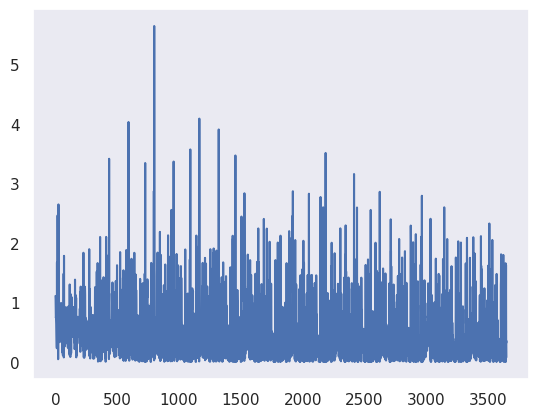

In [13]:
plt.plot(train_losses)

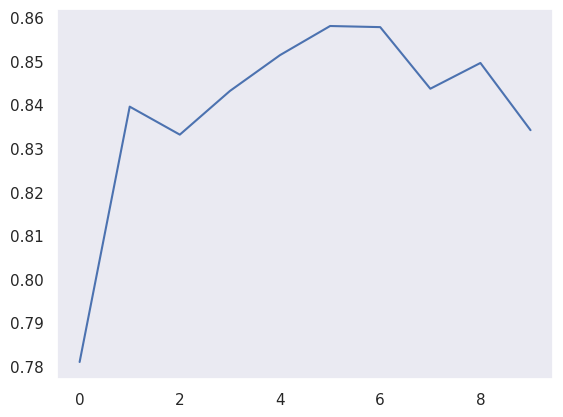

In [14]:
plt.plot(test_accuracy)

In [15]:
model_path = '../physio16k_fold2_m13mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [16]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [17]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3244/3872 (0.8378)
{'acc_detail': tensor([0.4574, 0.9598], device='cuda:0'),
 'acc_unweighted': tensor(0.7086, device='cuda:0'),
 'acc_weighted': tensor(0.8378, device='cuda:0'),
 'f1s_detail': tensor([0.5780, 0.8996], device='cuda:0'),
 'f1s_unweighted': tensor(0.7388, device='cuda:0'),
 'f1s_weighted': tensor(0.8215, device='cuda:0'),
 'precision_detail': tensor([0.7847, 0.8466], device='cuda:0'),
 'recall_detail': tensor([0.4574, 0.9598], device='cuda:0'),
 'rocauc': tensor(0.8693, device='cuda:0'),
 'rocauc_detail': tensor([0.8693, 0.8693], device='cuda:0'),
 'uar': tensor(0.7086, device='cuda:0'),
 'wap': tensor(0.8315, device='cuda:0')}


tensor([[ 430,  510],
        [ 118, 2814]], device='cuda:0')

In [18]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                         | 0.00411522633744856/50 [00:00<1:12:39, 87.20s/it]

Train Epoch: 11 [0/11685 (0%)]	Loss: 0.019785
Mem before-during-after: 17887744 18033664 18510336


  0%|▏                                                                                                        | 0.08641975308641978/50 [00:07<1:12:39, 87.34s/it]

Train Epoch: 11 [1280/11685 (11%)]	Loss: 0.040708
Mem before-during-after: 18510336 18655232 18510336


  0%|▎                                                                                                        | 0.16872427983539084/50 [00:14<1:14:12, 89.34s/it]

Train Epoch: 11 [2560/11685 (22%)]	Loss: 0.271370
Mem before-during-after: 18510336 18655232 18510336


  1%|▌                                                                                                        | 0.25102880658436166/50 [00:21<1:11:18, 86.00s/it]

Train Epoch: 11 [3840/11685 (33%)]	Loss: 0.068256
Mem before-during-after: 18510336 18655232 18510336


  1%|▋                                                                                                         | 0.3333333333333325/50 [00:28<1:11:35, 86.50s/it]

Train Epoch: 11 [5120/11685 (44%)]	Loss: 0.843729
Mem before-during-after: 18510336 18655232 18510336


  1%|▉                                                                                                         | 0.4156378600823033/50 [00:36<1:11:09, 86.11s/it]

Train Epoch: 11 [6400/11685 (55%)]	Loss: 0.170337
Mem before-during-after: 18510336 18655232 18510336


  1%|█                                                                                                         | 0.4979423868312741/50 [00:43<1:11:54, 87.16s/it]

Train Epoch: 11 [7680/11685 (66%)]	Loss: 0.547859
Mem before-during-after: 18510336 18655232 18510336


  1%|█▏                                                                                                         | 0.580246913580247/50 [00:50<1:09:54, 84.88s/it]

Train Epoch: 11 [8960/11685 (77%)]	Loss: 0.667502
Mem before-during-after: 18510336 18655232 18510336


  1%|█▍                                                                                                        | 0.6625514403292201/50 [00:57<1:12:19, 87.96s/it]

Train Epoch: 11 [10240/11685 (88%)]	Loss: 0.780440
Mem before-during-after: 18510336 18655232 18510336


  1%|█▌                                                                                                        | 0.7448559670781931/50 [01:04<1:10:03, 85.34s/it]

Train Epoch: 11 [11520/11685 (99%)]	Loss: 0.482329
Mem before-during-after: 18510336 18655232 18510336


  2%|██                                                                                                        | 1.0020576131687338/50 [01:26<1:11:04, 87.03s/it]


Test Epoch: 11	Accuracy: 3389/3872 (87%)

Train Epoch: 12 [0/11685 (0%)]	Loss: 0.006375
Mem before-during-after: 18509312 18655232 18510336


  2%|██▎                                                                                                       | 1.0864197530864266/50 [01:33<1:11:38, 87.87s/it]

Train Epoch: 12 [1280/11685 (11%)]	Loss: 0.009069
Mem before-during-after: 18510336 18655232 18510336


  2%|██▍                                                                                                       | 1.1687242798353952/50 [01:41<1:11:42, 88.11s/it]

Train Epoch: 12 [2560/11685 (22%)]	Loss: 0.262911
Mem before-during-after: 18510336 18655232 18510336


  3%|██▋                                                                                                       | 1.2510288065843638/50 [01:48<1:09:06, 85.07s/it]

Train Epoch: 12 [3840/11685 (33%)]	Loss: 0.044881
Mem before-during-after: 18510336 18655232 18510336


  3%|██▊                                                                                                       | 1.3333333333333324/50 [01:55<1:13:41, 90.84s/it]

Train Epoch: 12 [5120/11685 (44%)]	Loss: 0.684003
Mem before-during-after: 18510336 18655232 18510336


  3%|███                                                                                                        | 1.415637860082301/50 [02:02<1:10:10, 86.65s/it]

Train Epoch: 12 [6400/11685 (55%)]	Loss: 0.153123
Mem before-during-after: 18510336 18655232 18510336


  3%|███▏                                                                                                      | 1.4979423868312696/50 [02:09<1:09:28, 85.94s/it]

Train Epoch: 12 [7680/11685 (66%)]	Loss: 0.510121
Mem before-during-after: 18510336 18655232 18510336


  3%|███▎                                                                                                      | 1.5802469135802382/50 [02:16<1:07:10, 83.24s/it]

Train Epoch: 12 [8960/11685 (77%)]	Loss: 0.722357
Mem before-during-after: 18510336 18655232 18510336


  3%|███▌                                                                                                      | 1.6625514403292068/50 [02:24<1:09:35, 86.37s/it]

Train Epoch: 12 [10240/11685 (88%)]	Loss: 0.953128
Mem before-during-after: 18510336 18655232 18510336


  3%|███▋                                                                                                      | 1.7448559670781754/50 [02:31<1:10:06, 87.17s/it]

Train Epoch: 12 [11520/11685 (99%)]	Loss: 0.537351
Mem before-during-after: 18510336 18655232 18510336


  4%|████▏                                                                                                     | 2.0020576131687022/50 [02:53<1:08:02, 85.05s/it]


Test Epoch: 12	Accuracy: 3383/3872 (87%)

Train Epoch: 13 [0/11685 (0%)]	Loss: 0.005372
Mem before-during-after: 18509312 18655232 18510336


  4%|████▍                                                                                                      | 2.086419753086404/50 [03:00<1:08:41, 86.01s/it]

Train Epoch: 13 [1280/11685 (11%)]	Loss: 0.004692
Mem before-during-after: 18510336 18655232 18510336


  4%|████▌                                                                                                     | 2.1687242798353816/50 [03:07<1:08:48, 86.32s/it]

Train Epoch: 13 [2560/11685 (22%)]	Loss: 0.243508
Mem before-during-after: 18510336 18655232 18510336


  5%|████▊                                                                                                      | 2.251028806584359/50 [03:14<1:08:18, 85.84s/it]

Train Epoch: 13 [3840/11685 (33%)]	Loss: 0.044695
Mem before-during-after: 18510336 18655232 18510336


  5%|████▉                                                                                                     | 2.3333333333333366/50 [03:21<1:08:21, 86.04s/it]

Train Epoch: 13 [5120/11685 (44%)]	Loss: 0.659380
Mem before-during-after: 18510336 18655232 18510336


  5%|█████▏                                                                                                     | 2.415637860082314/50 [03:28<1:07:01, 84.51s/it]

Train Epoch: 13 [6400/11685 (55%)]	Loss: 0.141880
Mem before-during-after: 18510336 18655232 18510336


  5%|█████▎                                                                                                    | 2.4979423868312916/50 [03:36<1:08:13, 86.17s/it]

Train Epoch: 13 [7680/11685 (66%)]	Loss: 0.747703
Mem before-during-after: 18510336 18655232 18510336


  5%|█████▌                                                                                                     | 2.580246913580269/50 [03:43<1:11:15, 90.15s/it]

Train Epoch: 13 [8960/11685 (77%)]	Loss: 0.666825
Mem before-during-after: 18510336 18655232 18510336


  5%|█████▋                                                                                                    | 2.6625514403292465/50 [03:51<1:09:49, 88.51s/it]

Train Epoch: 13 [10240/11685 (88%)]	Loss: 1.176922
Mem before-during-after: 18510336 18655232 18510336


  5%|█████▊                                                                                                     | 2.744855967078224/50 [03:59<1:11:14, 90.45s/it]

Train Epoch: 13 [11520/11685 (99%)]	Loss: 0.593066
Mem before-during-after: 18510336 18655232 18510336


  6%|██████▎                                                                                                   | 3.0020576131687786/50 [04:22<1:08:46, 87.81s/it]


Test Epoch: 13	Accuracy: 3373/3872 (87%)

Train Epoch: 14 [0/11685 (0%)]	Loss: 0.004385
Mem before-during-after: 18509312 18655232 18510336


  6%|██████▌                                                                                                   | 3.0864197530864805/50 [04:30<1:08:39, 87.82s/it]

Train Epoch: 14 [1280/11685 (11%)]	Loss: 0.003049
Mem before-during-after: 18510336 18655232 18510336


  6%|██████▋                                                                                                   | 3.1666666666667336/50 [04:37<1:08:07, 87.27s/it]

Train Epoch: 14 [2560/11685 (22%)]	Loss: 0.222365
Mem before-during-after: 18510336 18655232 18510336


  7%|██████▉                                                                                                   | 3.2510288065844355/50 [04:44<1:07:21, 86.46s/it]

Train Epoch: 14 [3840/11685 (33%)]	Loss: 0.041137
Mem before-during-after: 18510336 18655232 18510336


  7%|███████▏                                                                                                   | 3.333333333333413/50 [04:51<1:06:57, 86.10s/it]

Train Epoch: 14 [5120/11685 (44%)]	Loss: 0.626135
Mem before-during-after: 18510336 18655232 18510336


  7%|███████▏                                                                                                  | 3.4156378600823905/50 [04:59<1:09:03, 88.94s/it]

Train Epoch: 14 [6400/11685 (55%)]	Loss: 0.124064
Mem before-during-after: 18510336 18655232 18510336


  7%|███████▍                                                                                                   | 3.497942386831368/50 [05:06<1:07:32, 87.15s/it]

Train Epoch: 14 [7680/11685 (66%)]	Loss: 0.863753
Mem before-during-after: 18510336 18655232 18510336


  7%|███████▌                                                                                                  | 3.5802469135803454/50 [05:14<1:08:11, 88.14s/it]

Train Epoch: 14 [8960/11685 (77%)]	Loss: 0.628591
Mem before-during-after: 18510336 18655232 18510336


  7%|███████▊                                                                                                  | 3.6604938271605985/50 [05:21<1:07:16, 87.11s/it]

Train Epoch: 14 [10240/11685 (88%)]	Loss: 1.173597
Mem before-during-after: 18510336 18655232 18510336


  7%|████████                                                                                                   | 3.742798353909576/50 [05:28<1:06:34, 86.36s/it]

Train Epoch: 14 [11520/11685 (99%)]	Loss: 0.532078
Mem before-during-after: 18510336 18655232 18510336


  8%|████████▌                                                                                                  | 4.002057613168855/50 [05:51<1:07:36, 88.19s/it]


Test Epoch: 14	Accuracy: 3394/3872 (87%)

Train Epoch: 15 [0/11685 (0%)]	Loss: 0.005218
Mem before-during-after: 18509312 18655232 18510336


  8%|████████▋                                                                                                  | 4.086419753086557/50 [05:58<1:06:17, 86.62s/it]

Train Epoch: 15 [1280/11685 (11%)]	Loss: 0.001946
Mem before-during-after: 18510336 18655232 18510336


  8%|████████▉                                                                                                  | 4.168724279835534/50 [06:06<1:08:02, 89.08s/it]

Train Epoch: 15 [2560/11685 (22%)]	Loss: 0.210500
Mem before-during-after: 18510336 18655232 18510336


  8%|█████████                                                                                                  | 4.248971193415787/50 [06:13<1:06:29, 87.21s/it]

Train Epoch: 15 [3840/11685 (33%)]	Loss: 0.030992
Mem before-during-after: 18510336 18655232 18510336


  9%|█████████▎                                                                                                 | 4.333333333333489/50 [06:20<1:09:50, 91.76s/it]

Train Epoch: 15 [5120/11685 (44%)]	Loss: 0.557581
Mem before-during-after: 18510336 18655232 18510336


  9%|█████████▍                                                                                                 | 4.413580246913742/50 [06:28<1:05:20, 86.01s/it]

Train Epoch: 15 [6400/11685 (55%)]	Loss: 0.122101
Mem before-during-after: 18510336 18655232 18510336


  9%|█████████▋                                                                                                  | 4.49588477366272/50 [06:35<1:07:09, 88.54s/it]

Train Epoch: 15 [7680/11685 (66%)]	Loss: 0.649750
Mem before-during-after: 18510336 18655232 18510336


  9%|█████████▊                                                                                                 | 4.580246913580422/50 [06:42<1:06:38, 88.03s/it]

Train Epoch: 15 [8960/11685 (77%)]	Loss: 0.499429
Mem before-during-after: 18510336 18655232 18510336


  9%|█████████▉                                                                                                 | 4.662551440329399/50 [06:50<1:07:13, 88.96s/it]

Train Epoch: 15 [10240/11685 (88%)]	Loss: 1.132330
Mem before-during-after: 18510336 18655232 18510336


  9%|██████████▏                                                                                                | 4.744855967078377/50 [06:57<1:06:10, 87.73s/it]

Train Epoch: 15 [11520/11685 (99%)]	Loss: 0.550112
Mem before-during-after: 18510336 18655232 18510336


 10%|██████████▋                                                                                                | 5.000000000000207/50 [07:20<1:05:50, 87.78s/it]


Test Epoch: 15	Accuracy: 3395/3872 (87%)



 10%|██████████▋                                                                                                | 5.004115226337656/50 [07:20<1:07:44, 90.34s/it]

Train Epoch: 16 [0/11685 (0%)]	Loss: 0.005751
Mem before-during-after: 18509312 18655232 18510336


 10%|██████████▉                                                                                                | 5.086419753086633/50 [07:27<1:06:58, 89.48s/it]

Train Epoch: 16 [1280/11685 (11%)]	Loss: 0.001675
Mem before-during-after: 18510336 18655232 18510336


 10%|███████████                                                                                                | 5.168724279835611/50 [07:35<1:04:07, 85.81s/it]

Train Epoch: 16 [2560/11685 (22%)]	Loss: 0.210597
Mem before-during-after: 18510336 18655232 18510336


 11%|███████████▏                                                                                               | 5.251028806584588/50 [07:42<1:05:12, 87.43s/it]

Train Epoch: 16 [3840/11685 (33%)]	Loss: 0.023828
Mem before-during-after: 18510336 18655232 18510336


 11%|███████████▍                                                                                               | 5.333333333333566/50 [07:49<1:06:14, 88.98s/it]

Train Epoch: 16 [5120/11685 (44%)]	Loss: 0.466455
Mem before-during-after: 18510336 18655232 18510336


 11%|███████████▌                                                                                               | 5.415637860082543/50 [07:57<1:05:23, 88.00s/it]

Train Epoch: 16 [6400/11685 (55%)]	Loss: 0.093624
Mem before-during-after: 18510336 18655232 18510336


 11%|███████████▊                                                                                               | 5.497942386831521/50 [08:04<1:05:18, 88.05s/it]

Train Epoch: 16 [7680/11685 (66%)]	Loss: 0.651830
Mem before-during-after: 18510336 18655232 18510336


 11%|███████████▉                                                                                               | 5.580246913580498/50 [08:12<1:05:30, 88.49s/it]

Train Epoch: 16 [8960/11685 (77%)]	Loss: 0.394285
Mem before-during-after: 18510336 18655232 18510336


 11%|████████████                                                                                               | 5.662551440329476/50 [08:19<1:03:44, 86.27s/it]

Train Epoch: 16 [10240/11685 (88%)]	Loss: 1.112953
Mem before-during-after: 18510336 18655232 18510336


 11%|████████████▎                                                                                              | 5.744855967078453/50 [08:26<1:03:52, 86.60s/it]

Train Epoch: 16 [11520/11685 (99%)]	Loss: 0.520850
Mem before-during-after: 18510336 18655232 18510336


 12%|████████████▊                                                                                              | 6.002057613169008/50 [08:49<1:06:57, 91.32s/it]


Test Epoch: 16	Accuracy: 3401/3872 (87%)

Train Epoch: 17 [0/11685 (0%)]	Loss: 0.007245
Mem before-during-after: 18509312 18655232 18510336


 12%|█████████████▏                                                                                              | 6.08641975308671/50 [08:57<1:04:28, 88.09s/it]

Train Epoch: 17 [1280/11685 (11%)]	Loss: 0.001169
Mem before-during-after: 18510336 18655232 18510336


 12%|█████████████▏                                                                                             | 6.168724279835687/50 [09:04<1:05:03, 89.06s/it]

Train Epoch: 17 [2560/11685 (22%)]	Loss: 0.210476
Mem before-during-after: 18510336 18655232 18510336


 12%|█████████████▍                                                                                              | 6.24897119341594/50 [09:11<1:06:04, 90.61s/it]

Train Epoch: 17 [3840/11685 (33%)]	Loss: 0.022845
Mem before-during-after: 18510336 18655232 18510336


 13%|█████████████▌                                                                                             | 6.333333333333642/50 [09:19<1:05:53, 90.54s/it]

Train Epoch: 17 [5120/11685 (44%)]	Loss: 0.422336
Mem before-during-after: 18510336 18655232 18510336


 13%|█████████████▊                                                                                              | 6.41563786008262/50 [09:26<1:05:33, 90.24s/it]

Train Epoch: 17 [6400/11685 (55%)]	Loss: 0.069662
Mem before-during-after: 18510336 18655232 18510336


 13%|█████████████▉                                                                                             | 6.497942386831597/50 [09:33<1:03:22, 87.41s/it]

Train Epoch: 17 [7680/11685 (66%)]	Loss: 0.689365
Mem before-during-after: 18510336 18655232 18510336


 13%|██████████████                                                                                             | 6.580246913580575/50 [09:41<1:03:15, 87.42s/it]

Train Epoch: 17 [8960/11685 (77%)]	Loss: 0.368713
Mem before-during-after: 18510336 18655232 18510336


 13%|██████████████▎                                                                                            | 6.662551440329552/50 [09:48<1:02:15, 86.20s/it]

Train Epoch: 17 [10240/11685 (88%)]	Loss: 1.119540
Mem before-during-after: 18510336 18655232 18510336


 13%|██████████████▎                                                                                           | 6.7448559670785295/50 [09:55<1:05:42, 91.14s/it]

Train Epoch: 17 [11520/11685 (99%)]	Loss: 0.526726
Mem before-during-after: 18510336 18655232 18510336


 14%|██████████████▉                                                                                            | 7.002057613169084/50 [10:18<1:01:59, 86.51s/it]


Test Epoch: 17	Accuracy: 3393/3872 (87%)

Train Epoch: 18 [0/11685 (0%)]	Loss: 0.004662
Mem before-during-after: 18509312 18655232 18510336


 14%|███████████████▏                                                                                           | 7.086419753086786/50 [10:25<1:03:36, 88.93s/it]

Train Epoch: 18 [1280/11685 (11%)]	Loss: 0.000859
Mem before-during-after: 18510336 18655232 18510336


 14%|███████████████▏                                                                                          | 7.1687242798357635/50 [10:33<1:02:33, 87.64s/it]

Train Epoch: 18 [2560/11685 (22%)]	Loss: 0.211653
Mem before-during-after: 18510336 18655232 18510336


 15%|███████████████▌                                                                                           | 7.251028806584741/50 [10:40<1:01:55, 86.92s/it]

Train Epoch: 18 [3840/11685 (33%)]	Loss: 0.028108
Mem before-during-after: 18510336 18655232 18510336


 15%|███████████████▌                                                                                          | 7.3333333333337185/50 [10:47<1:04:15, 90.37s/it]

Train Epoch: 18 [5120/11685 (44%)]	Loss: 0.394679
Mem before-during-after: 18510336 18655232 18510336


 15%|███████████████▊                                                                                           | 7.415637860082696/50 [10:55<1:02:46, 88.44s/it]

Train Epoch: 18 [6400/11685 (55%)]	Loss: 0.076692
Mem before-during-after: 18510336 18655232 18510336


 15%|████████████████                                                                                           | 7.495884773662949/50 [11:02<1:01:31, 86.85s/it]

Train Epoch: 18 [7680/11685 (66%)]	Loss: 0.913825
Mem before-during-after: 18510336 18655232 18510336


 15%|████████████████▏                                                                                          | 7.580246913580651/50 [11:09<1:03:16, 89.50s/it]

Train Epoch: 18 [8960/11685 (77%)]	Loss: 0.277124
Mem before-during-after: 18510336 18655232 18510336


 15%|████████████████▍                                                                                          | 7.660493827160904/50 [11:17<1:01:43, 87.48s/it]

Train Epoch: 18 [10240/11685 (88%)]	Loss: 1.039381
Mem before-during-after: 18510336 18655232 18510336


 15%|████████████████▌                                                                                          | 7.744855967078606/50 [11:24<1:00:35, 86.03s/it]

Train Epoch: 18 [11520/11685 (99%)]	Loss: 0.505265
Mem before-during-after: 18510336 18655232 18510336


 16%|█████████████████                                                                                          | 8.002057613169159/50 [11:47<1:03:30, 90.72s/it]


Test Epoch: 18	Accuracy: 3377/3872 (87%)

Train Epoch: 19 [0/11685 (0%)]	Loss: 0.006319
Mem before-during-after: 18509312 18655232 18510336


 16%|█████████████████▎                                                                                         | 8.086419753086824/50 [11:54<1:01:40, 88.28s/it]

Train Epoch: 19 [1280/11685 (11%)]	Loss: 0.000742
Mem before-during-after: 18510336 18655232 18510336


 16%|█████████████████▍                                                                                         | 8.168724279835766/50 [12:02<1:01:24, 88.07s/it]

Train Epoch: 19 [2560/11685 (22%)]	Loss: 0.202611
Mem before-during-after: 18510336 18655232 18510336


 17%|█████████████████▋                                                                                         | 8.251028806584708/50 [12:09<1:01:05, 87.79s/it]

Train Epoch: 19 [3840/11685 (33%)]	Loss: 0.036586
Mem before-during-after: 18510336 18655232 18510336


 17%|██████████████████▎                                                                                           | 8.33333333333365/50 [12:16<59:40, 85.94s/it]

Train Epoch: 19 [5120/11685 (44%)]	Loss: 0.400442
Mem before-during-after: 18510336 18655232 18510336


 17%|██████████████████▎                                                                                          | 8.415637860082592/50 [12:23<59:29, 85.83s/it]

Train Epoch: 19 [6400/11685 (55%)]	Loss: 0.055248
Mem before-during-after: 18510336 18655232 18510336


 17%|██████████████████▏                                                                                        | 8.497942386831534/50 [12:30<1:00:04, 86.85s/it]

Train Epoch: 19 [7680/11685 (66%)]	Loss: 0.722019
Mem before-during-after: 18510336 18655232 18510336


 17%|██████████████████▋                                                                                          | 8.580246913580476/50 [12:38<59:34, 86.31s/it]

Train Epoch: 19 [8960/11685 (77%)]	Loss: 0.411133
Mem before-during-after: 18510336 18655232 18510336


 17%|██████████████████▉                                                                                          | 8.662551440329418/50 [12:45<59:31, 86.40s/it]

Train Epoch: 19 [10240/11685 (88%)]	Loss: 1.123851
Mem before-during-after: 18510336 18655232 18510336


 17%|███████████████████▏                                                                                          | 8.74485596707836/50 [12:52<59:38, 86.75s/it]

Train Epoch: 19 [11520/11685 (99%)]	Loss: 0.512893
Mem before-during-after: 18510336 18655232 18510336


 18%|███████████████████▌                                                                                         | 9.002057613168803/50 [13:14<58:58, 86.32s/it]


Test Epoch: 19	Accuracy: 3348/3872 (86%)

Train Epoch: 20 [0/11685 (0%)]	Loss: 0.005815
Mem before-during-after: 18509312 18655232 18510336


 18%|███████████████████▊                                                                                         | 9.086419753086469/50 [13:21<59:24, 87.13s/it]

Train Epoch: 20 [1280/11685 (11%)]	Loss: 0.000468
Mem before-during-after: 18510336 18655232 18510336


 18%|███████████████████▉                                                                                         | 9.168724279835411/50 [13:29<59:30, 87.44s/it]

Train Epoch: 20 [2560/11685 (22%)]	Loss: 0.194191
Mem before-during-after: 18510336 18655232 18510336


 19%|████████████████████▏                                                                                        | 9.251028806584353/50 [13:36<59:04, 86.98s/it]

Train Epoch: 20 [3840/11685 (33%)]	Loss: 0.028422
Mem before-during-after: 18510336 18655232 18510336


 19%|████████████████████▎                                                                                        | 9.333333333333295/50 [13:43<58:09, 85.80s/it]

Train Epoch: 20 [5120/11685 (44%)]	Loss: 0.424775
Mem before-during-after: 18510336 18655232 18510336


 19%|████████████████████▌                                                                                        | 9.415637860082237/50 [13:50<58:03, 85.83s/it]

Train Epoch: 20 [6400/11685 (55%)]	Loss: 0.054702
Mem before-during-after: 18510336 18655232 18510336


 19%|████████████████████▋                                                                                        | 9.497942386831179/50 [13:57<58:43, 86.99s/it]

Train Epoch: 20 [7680/11685 (66%)]	Loss: 0.875607
Mem before-during-after: 18510336 18655232 18510336


 19%|████████████████████▉                                                                                        | 9.578189300411397/50 [14:04<57:53, 85.93s/it]

Train Epoch: 20 [8960/11685 (77%)]	Loss: 0.333880
Mem before-during-after: 18510336 18655232 18510336


 19%|█████████████████████                                                                                        | 9.662551440329063/50 [14:11<57:59, 86.25s/it]

Train Epoch: 20 [10240/11685 (88%)]	Loss: 1.172089
Mem before-during-after: 18510336 18655232 18510336


 19%|█████████████████████▏                                                                                       | 9.744855967078005/50 [14:19<58:44, 87.55s/it]

Train Epoch: 20 [11520/11685 (99%)]	Loss: 0.489000
Mem before-during-after: 18510336 18655232 18510336


 20%|█████████████████████▌                                                                                      | 10.002057613168448/50 [14:41<59:10, 88.77s/it]


Test Epoch: 20	Accuracy: 3366/3872 (87%)

Train Epoch: 21 [0/11685 (0%)]	Loss: 0.005317
Mem before-during-after: 18509312 18655232 18510336


 20%|█████████████████████▊                                                                                      | 10.086419753086114/50 [14:48<57:31, 86.47s/it]

Train Epoch: 21 [1280/11685 (11%)]	Loss: 0.000229
Mem before-during-after: 18510336 18655232 18510336


 20%|█████████████████████▉                                                                                      | 10.168724279835056/50 [14:55<57:25, 86.49s/it]

Train Epoch: 21 [2560/11685 (22%)]	Loss: 0.196107
Mem before-during-after: 18510336 18655232 18510336


 21%|██████████████████████▏                                                                                     | 10.251028806583998/50 [15:02<57:03, 86.13s/it]

Train Epoch: 21 [3840/11685 (33%)]	Loss: 0.026251
Mem before-during-after: 18510336 18655232 18510336


 21%|██████████████████████▌                                                                                      | 10.33333333333294/50 [15:09<56:33, 85.56s/it]

Train Epoch: 21 [5120/11685 (44%)]	Loss: 0.480326
Mem before-during-after: 18510336 18655232 18510336


 21%|██████████████████████▍                                                                                     | 10.415637860081882/50 [15:17<56:40, 85.92s/it]

Train Epoch: 21 [6400/11685 (55%)]	Loss: 0.046877
Mem before-during-after: 18510336 18655232 18510336


 21%|██████████████████████▋                                                                                     | 10.497942386830823/50 [15:24<57:19, 87.07s/it]

Train Epoch: 21 [7680/11685 (66%)]	Loss: 0.969814
Mem before-during-after: 18510336 18655232 18510336


 21%|██████████████████████▊                                                                                     | 10.580246913579765/50 [15:31<58:17, 88.72s/it]

Train Epoch: 21 [8960/11685 (77%)]	Loss: 0.276655
Mem before-during-after: 18510336 18655232 18510336


 21%|███████████████████████                                                                                     | 10.662551440328707/50 [15:38<56:29, 86.16s/it]

Train Epoch: 21 [10240/11685 (88%)]	Loss: 1.139341
Mem before-during-after: 18510336 18655232 18510336


 21%|███████████████████████▍                                                                                     | 10.74485596707765/50 [15:45<58:27, 89.36s/it]

Train Epoch: 21 [11520/11685 (99%)]	Loss: 0.504289
Mem before-during-after: 18510336 18655232 18510336


 22%|███████████████████████▊                                                                                    | 11.002057613168093/50 [16:07<54:44, 84.21s/it]


Test Epoch: 21	Accuracy: 3419/3872 (88%)

Train Epoch: 22 [0/11685 (0%)]	Loss: 0.005638
Mem before-during-after: 18509312 18655232 18510336


 22%|███████████████████████▉                                                                                    | 11.086419753085758/50 [16:15<54:48, 84.52s/it]

Train Epoch: 22 [1280/11685 (11%)]	Loss: 0.000299
Mem before-during-after: 18510336 18655232 18510336


 22%|████████████████████████▌                                                                                     | 11.1687242798347/50 [16:22<59:36, 92.12s/it]

Train Epoch: 22 [2560/11685 (22%)]	Loss: 0.207706
Mem before-during-after: 18510336 18655232 18510336


 23%|████████████████████████▎                                                                                   | 11.251028806583642/50 [16:29<57:06, 88.43s/it]

Train Epoch: 22 [3840/11685 (33%)]	Loss: 0.026162
Mem before-during-after: 18510336 18655232 18510336


 23%|████████████████████████▍                                                                                   | 11.333333333332584/50 [16:36<57:08, 88.68s/it]

Train Epoch: 22 [5120/11685 (44%)]	Loss: 0.450494
Mem before-during-after: 18510336 18655232 18510336


 23%|████████████████████████▋                                                                                   | 11.415637860081526/50 [16:43<57:20, 89.17s/it]

Train Epoch: 22 [6400/11685 (55%)]	Loss: 0.057013
Mem before-during-after: 18510336 18655232 18510336


 23%|████████████████████████▊                                                                                   | 11.497942386830468/50 [16:51<55:55, 87.15s/it]

Train Epoch: 22 [7680/11685 (66%)]	Loss: 1.017489
Mem before-during-after: 18510336 18655232 18510336


 23%|█████████████████████████▏                                                                                   | 11.58024691357941/50 [16:58<56:26, 88.14s/it]

Train Epoch: 22 [8960/11685 (77%)]	Loss: 0.489678
Mem before-during-after: 18510336 18655232 18510336


 23%|█████████████████████████▏                                                                                  | 11.660493827159629/50 [17:05<54:58, 86.04s/it]

Train Epoch: 22 [10240/11685 (88%)]	Loss: 1.227308
Mem before-during-after: 18510336 18655232 18510336


 23%|█████████████████████████▎                                                                                  | 11.744855967077294/50 [17:12<55:10, 86.54s/it]

Train Epoch: 22 [11520/11685 (99%)]	Loss: 0.518500
Mem before-during-after: 18510336 18655232 18510336


 24%|█████████████████████████▉                                                                                  | 12.002057613167738/50 [17:34<54:27, 85.98s/it]


Test Epoch: 22	Accuracy: 3399/3872 (87%)

Train Epoch: 23 [0/11685 (0%)]	Loss: 0.005167
Mem before-during-after: 18509312 18655232 18510336


 24%|██████████████████████████                                                                                  | 12.086419753085403/50 [17:42<54:37, 86.44s/it]

Train Epoch: 23 [1280/11685 (11%)]	Loss: 0.000608
Mem before-during-after: 18510336 18655232 18510336


 24%|██████████████████████████▎                                                                                 | 12.168724279834345/50 [17:49<53:39, 85.10s/it]

Train Epoch: 23 [2560/11685 (22%)]	Loss: 0.202170
Mem before-during-after: 18510336 18655232 18510336


 25%|██████████████████████████▍                                                                                 | 12.251028806583287/50 [17:56<53:56, 85.74s/it]

Train Epoch: 23 [3840/11685 (33%)]	Loss: 0.031689
Mem before-during-after: 18510336 18655232 18510336


 25%|██████████████████████████▋                                                                                 | 12.333333333332229/50 [18:03<55:23, 88.23s/it]

Train Epoch: 23 [5120/11685 (44%)]	Loss: 0.510716
Mem before-during-after: 18510336 18655232 18510336


 25%|██████████████████████████▊                                                                                 | 12.415637860081171/50 [18:10<54:09, 86.47s/it]

Train Epoch: 23 [6400/11685 (55%)]	Loss: 0.057808
Mem before-during-after: 18510336 18655232 18510336


 25%|██████████████████████████▉                                                                                 | 12.497942386830113/50 [18:18<54:42, 87.52s/it]

Train Epoch: 23 [7680/11685 (66%)]	Loss: 1.121656
Mem before-during-after: 18510336 18655232 18510336


 25%|███████████████████████████▏                                                                                | 12.580246913579055/50 [18:25<53:41, 86.08s/it]

Train Epoch: 23 [8960/11685 (77%)]	Loss: 0.516683
Mem before-during-after: 18510336 18655232 18510336


 25%|███████████████████████████▎                                                                                | 12.662551440327997/50 [18:32<53:25, 85.85s/it]

Train Epoch: 23 [10240/11685 (88%)]	Loss: 1.172699
Mem before-during-after: 18510336 18655232 18510336


 25%|███████████████████████████▌                                                                                | 12.744855967076939/50 [18:39<54:13, 87.33s/it]

Train Epoch: 23 [11520/11685 (99%)]	Loss: 0.520015
Mem before-during-after: 18510336 18655232 18510336


 26%|████████████████████████████                                                                                | 12.999999999998659/50 [19:01<52:17, 84.81s/it]


Test Epoch: 23	Accuracy: 3419/3872 (88%)



 26%|████████████████████████████                                                                                | 13.004115226336106/50 [19:01<57:34, 93.38s/it]

Train Epoch: 24 [0/11685 (0%)]	Loss: 0.004093
Mem before-during-after: 18509312 18655232 18510336


 26%|████████████████████████████▎                                                                               | 13.086419753085048/50 [19:09<54:28, 88.53s/it]

Train Epoch: 24 [1280/11685 (11%)]	Loss: 0.000372
Mem before-during-after: 18510336 18655232 18510336


 26%|████████████████████████████▋                                                                                | 13.16872427983399/50 [19:16<53:28, 87.10s/it]

Train Epoch: 24 [2560/11685 (22%)]	Loss: 0.213544
Mem before-during-after: 18510336 18655232 18510336


 27%|████████████████████████████▌                                                                               | 13.251028806582932/50 [19:23<54:04, 88.29s/it]

Train Epoch: 24 [3840/11685 (33%)]	Loss: 0.020402
Mem before-during-after: 18510336 18655232 18510336


 27%|████████████████████████████▊                                                                               | 13.333333333331874/50 [19:30<52:45, 86.33s/it]

Train Epoch: 24 [5120/11685 (44%)]	Loss: 0.446804
Mem before-during-after: 18510336 18655232 18510336


 27%|████████████████████████████▉                                                                               | 13.415637860080816/50 [19:37<53:23, 87.56s/it]

Train Epoch: 24 [6400/11685 (55%)]	Loss: 0.062858
Mem before-during-after: 18510336 18655232 18510336


 27%|█████████████████████████████▏                                                                              | 13.497942386829758/50 [19:44<52:52, 86.91s/it]

Train Epoch: 24 [7680/11685 (66%)]	Loss: 1.074515
Mem before-during-after: 18510336 18655232 18510336


 27%|█████████████████████████████▉                                                                                | 13.5802469135787/50 [19:51<51:45, 85.27s/it]

Train Epoch: 24 [8960/11685 (77%)]	Loss: 0.578385
Mem before-during-after: 18510336 18655232 18510336


 27%|█████████████████████████████▌                                                                              | 13.662551440327642/50 [19:59<53:21, 88.11s/it]

Train Epoch: 24 [10240/11685 (88%)]	Loss: 1.014383
Mem before-during-after: 18510336 18655232 18510336


 27%|█████████████████████████████▋                                                                              | 13.744855967076584/50 [20:06<52:56, 87.62s/it]

Train Epoch: 24 [11520/11685 (99%)]	Loss: 0.476999
Mem before-during-after: 18510336 18655232 18510336


 28%|██████████████████████████████▏                                                                             | 14.002057613167027/50 [20:28<51:33, 85.92s/it]


Test Epoch: 24	Accuracy: 3401/3872 (87%)

Train Epoch: 25 [0/11685 (0%)]	Loss: 0.004799
Mem before-during-after: 18509312 18655232 18510336


 28%|██████████████████████████████▍                                                                             | 14.086419753084693/50 [20:35<51:40, 86.34s/it]

Train Epoch: 25 [1280/11685 (11%)]	Loss: 0.000382
Mem before-during-after: 18510336 18655232 18510336


 28%|██████████████████████████████▌                                                                             | 14.168724279833635/50 [20:42<52:25, 87.78s/it]

Train Epoch: 25 [2560/11685 (22%)]	Loss: 0.181234
Mem before-during-after: 18510336 18655232 18510336


 29%|██████████████████████████████▊                                                                             | 14.251028806582577/50 [20:50<51:45, 86.87s/it]

Train Epoch: 25 [3840/11685 (33%)]	Loss: 0.029288
Mem before-during-after: 18510336 18655232 18510336


 29%|██████████████████████████████▉                                                                             | 14.333333333331518/50 [20:57<51:52, 87.26s/it]

Train Epoch: 25 [5120/11685 (44%)]	Loss: 0.634557
Mem before-during-after: 18510336 18655232 18510336


 29%|███████████████████████████████▍                                                                             | 14.41563786008046/50 [21:04<50:40, 85.46s/it]

Train Epoch: 25 [6400/11685 (55%)]	Loss: 0.065413
Mem before-during-after: 18510336 18655232 18510336


 29%|███████████████████████████████▎                                                                            | 14.497942386829402/50 [21:11<51:32, 87.12s/it]

Train Epoch: 25 [7680/11685 (66%)]	Loss: 1.345360
Mem before-during-after: 18510336 18655232 18510336


 29%|███████████████████████████████▍                                                                            | 14.580246913578344/50 [21:18<51:17, 86.88s/it]

Train Epoch: 25 [8960/11685 (77%)]	Loss: 0.691074
Mem before-during-after: 18510336 18655232 18510336


 29%|███████████████████████████████▋                                                                            | 14.662551440327286/50 [21:25<51:52, 88.07s/it]

Train Epoch: 25 [10240/11685 (88%)]	Loss: 1.276683
Mem before-during-after: 18510336 18655232 18510336


 29%|███████████████████████████████▊                                                                            | 14.744855967076228/50 [21:33<50:34, 86.06s/it]

Train Epoch: 25 [11520/11685 (99%)]	Loss: 0.534655
Mem before-during-after: 18510336 18655232 18510336


 30%|████████████████████████████████▍                                                                           | 14.999999999997948/50 [21:55<49:33, 84.96s/it]


Test Epoch: 25	Accuracy: 3411/3872 (88%)



 30%|████████████████████████████████▍                                                                           | 15.004115226335395/50 [21:55<51:34, 88.42s/it]

Train Epoch: 26 [0/11685 (0%)]	Loss: 0.009735
Mem before-during-after: 18509312 18655232 18510336


 30%|████████████████████████████████▌                                                                           | 15.086419753084337/50 [22:02<50:25, 86.66s/it]

Train Epoch: 26 [1280/11685 (11%)]	Loss: 0.000308
Mem before-during-after: 18510336 18655232 18510336


 30%|█████████████████████████████████                                                                            | 15.16872427983328/50 [22:09<50:24, 86.83s/it]

Train Epoch: 26 [2560/11685 (22%)]	Loss: 0.178679
Mem before-during-after: 18510336 18655232 18510336


 31%|████████████████████████████████▉                                                                           | 15.251028806582221/50 [22:17<50:50, 87.77s/it]

Train Epoch: 26 [3840/11685 (33%)]	Loss: 0.026736
Mem before-during-after: 18510336 18655232 18510336


 31%|█████████████████████████████████                                                                           | 15.333333333331163/50 [22:24<49:47, 86.18s/it]

Train Epoch: 26 [5120/11685 (44%)]	Loss: 0.455245
Mem before-during-after: 18510336 18655232 18510336


 31%|█████████████████████████████████▎                                                                          | 15.415637860080105/50 [22:31<49:08, 85.26s/it]

Train Epoch: 26 [6400/11685 (55%)]	Loss: 0.071504
Mem before-during-after: 18510336 18655232 18510336


 31%|█████████████████████████████████▍                                                                          | 15.497942386829047/50 [22:38<49:02, 85.28s/it]

Train Epoch: 26 [7680/11685 (66%)]	Loss: 1.133010
Mem before-during-after: 18510336 18655232 18510336


 31%|█████████████████████████████████▋                                                                          | 15.580246913577989/50 [22:45<49:26, 86.18s/it]

Train Epoch: 26 [8960/11685 (77%)]	Loss: 0.876782
Mem before-during-after: 18510336 18655232 18510336


 31%|█████████████████████████████████▊                                                                          | 15.662551440326931/50 [22:52<49:28, 86.45s/it]

Train Epoch: 26 [10240/11685 (88%)]	Loss: 1.084773
Mem before-during-after: 18510336 18655232 18510336


 31%|██████████████████████████████████                                                                          | 15.744855967075873/50 [23:00<51:08, 89.57s/it]

Train Epoch: 26 [11520/11685 (99%)]	Loss: 0.511049
Mem before-during-after: 18510336 18655232 18510336


 32%|██████████████████████████████████▉                                                                          | 16.00205761316632/50 [23:22<48:32, 85.67s/it]


Test Epoch: 26	Accuracy: 3429/3872 (88%)

Train Epoch: 27 [0/11685 (0%)]	Loss: 0.008356
Mem before-during-after: 18509312 18655232 18510336


 32%|██████████████████████████████████▋                                                                         | 16.086419753083984/50 [23:29<48:56, 86.60s/it]

Train Epoch: 27 [1280/11685 (11%)]	Loss: 0.000633
Mem before-during-after: 18510336 18655232 18510336


 32%|██████████████████████████████████▉                                                                         | 16.168724279832926/50 [23:36<49:03, 87.01s/it]

Train Epoch: 27 [2560/11685 (22%)]	Loss: 0.184754
Mem before-during-after: 18510336 18655232 18510336


 33%|███████████████████████████████████                                                                         | 16.251028806581868/50 [23:44<47:56, 85.24s/it]

Train Epoch: 27 [3840/11685 (33%)]	Loss: 0.025858
Mem before-during-after: 18510336 18655232 18510336


 33%|███████████████████████████████████▌                                                                         | 16.33333333333081/50 [23:51<49:28, 88.17s/it]

Train Epoch: 27 [5120/11685 (44%)]	Loss: 0.525738
Mem before-during-after: 18510336 18655232 18510336


 33%|███████████████████████████████████▍                                                                        | 16.413580246911028/50 [23:58<49:10, 87.86s/it]

Train Epoch: 27 [6400/11685 (55%)]	Loss: 0.043079
Mem before-during-after: 18510336 18655232 18510336


 33%|███████████████████████████████████▋                                                                        | 16.497942386828694/50 [24:05<47:38, 85.33s/it]

Train Epoch: 27 [7680/11685 (66%)]	Loss: 1.277437
Mem before-during-after: 18510336 18655232 18510336


 33%|███████████████████████████████████▊                                                                        | 16.580246913577636/50 [24:12<47:46, 85.76s/it]

Train Epoch: 27 [8960/11685 (77%)]	Loss: 1.013188
Mem before-during-after: 18510336 18655232 18510336


 33%|███████████████████████████████████▉                                                                        | 16.662551440326578/50 [24:20<48:09, 86.68s/it]

Train Epoch: 27 [10240/11685 (88%)]	Loss: 1.120430
Mem before-during-after: 18510336 18655232 18510336


 33%|████████████████████████████████████▌                                                                        | 16.74485596707552/50 [24:27<49:27, 89.25s/it]

Train Epoch: 27 [11520/11685 (99%)]	Loss: 0.521912
Mem before-during-after: 18510336 18655232 18510336


 34%|████████████████████████████████████▋                                                                       | 17.002057613165963/50 [24:49<48:13, 87.70s/it]


Test Epoch: 27	Accuracy: 3434/3872 (88%)

Train Epoch: 28 [0/11685 (0%)]	Loss: 0.008491
Mem before-during-after: 18509312 18655232 18510336


 34%|█████████████████████████████████████▏                                                                       | 17.08641975308363/50 [24:56<47:44, 87.05s/it]

Train Epoch: 28 [1280/11685 (11%)]	Loss: 0.000753
Mem before-during-after: 18510336 18655232 18510336


 34%|█████████████████████████████████████▍                                                                       | 17.16872427983257/50 [25:03<47:11, 86.26s/it]

Train Epoch: 28 [2560/11685 (22%)]	Loss: 0.175353
Mem before-during-after: 18510336 18655232 18510336


 35%|█████████████████████████████████████▎                                                                      | 17.251028806581512/50 [25:11<47:10, 86.43s/it]

Train Epoch: 28 [3840/11685 (33%)]	Loss: 0.034785
Mem before-during-after: 18510336 18655232 18510336


 35%|█████████████████████████████████████▍                                                                      | 17.333333333330454/50 [25:18<47:22, 87.03s/it]

Train Epoch: 28 [5120/11685 (44%)]	Loss: 0.479533
Mem before-during-after: 18510336 18655232 18510336


 35%|█████████████████████████████████████▌                                                                      | 17.415637860079396/50 [25:25<45:54, 84.54s/it]

Train Epoch: 28 [6400/11685 (55%)]	Loss: 0.066608
Mem before-during-after: 18510336 18655232 18510336


 35%|██████████████████████████████████████▏                                                                      | 17.49794238682834/50 [25:32<46:20, 85.54s/it]

Train Epoch: 28 [7680/11685 (66%)]	Loss: 1.142393
Mem before-during-after: 18510336 18655232 18510336


 35%|██████████████████████████████████████▎                                                                      | 17.58024691357728/50 [25:39<47:06, 87.18s/it]

Train Epoch: 28 [8960/11685 (77%)]	Loss: 0.994817
Mem before-during-after: 18510336 18655232 18510336


 35%|██████████████████████████████████████▏                                                                     | 17.662551440326222/50 [25:47<46:12, 85.73s/it]

Train Epoch: 28 [10240/11685 (88%)]	Loss: 1.107063
Mem before-during-after: 18510336 18655232 18510336


 35%|██████████████████████████████████████▎                                                                     | 17.744855967075164/50 [25:54<46:09, 85.87s/it]

Train Epoch: 28 [11520/11685 (99%)]	Loss: 0.517321
Mem before-during-after: 18510336 18655232 18510336


 36%|██████████████████████████████████████▉                                                                     | 18.002057613165608/50 [26:16<52:03, 97.62s/it]


Test Epoch: 28	Accuracy: 3423/3872 (88%)

Train Epoch: 29 [0/11685 (0%)]	Loss: 0.008110
Mem before-during-after: 18509312 18655232 18510336


 36%|███████████████████████████████████████                                                                     | 18.086419753083273/50 [26:23<45:20, 85.25s/it]

Train Epoch: 29 [1280/11685 (11%)]	Loss: 0.001362
Mem before-during-after: 18510336 18655232 18510336


 36%|███████████████████████████████████████▌                                                                     | 18.16666666666349/50 [26:30<46:11, 87.05s/it]

Train Epoch: 29 [2560/11685 (22%)]	Loss: 0.174964
Mem before-during-after: 18510336 18655232 18510336


 37%|███████████████████████████████████████▍                                                                    | 18.251028806581157/50 [26:38<46:14, 87.39s/it]

Train Epoch: 29 [3840/11685 (33%)]	Loss: 0.030293
Mem before-during-after: 18510336 18655232 18510336


 37%|████████████████████████████████████████▎                                                                     | 18.3333333333301/50 [26:45<45:51, 86.88s/it]

Train Epoch: 29 [5120/11685 (44%)]	Loss: 0.485133
Mem before-during-after: 18510336 18655232 18510336


 37%|████████████████████████████████████████▏                                                                    | 18.41563786007904/50 [26:52<45:51, 87.10s/it]

Train Epoch: 29 [6400/11685 (55%)]	Loss: 0.067383
Mem before-during-after: 18510336 18655232 18510336


 37%|███████████████████████████████████████▉                                                                    | 18.497942386827983/50 [26:59<45:07, 85.95s/it]

Train Epoch: 29 [7680/11685 (66%)]	Loss: 1.201301
Mem before-during-after: 18510336 18655232 18510336


 37%|████████████████████████████████████████▏                                                                   | 18.580246913576925/50 [27:07<45:25, 86.73s/it]

Train Epoch: 29 [8960/11685 (77%)]	Loss: 1.108710
Mem before-during-after: 18510336 18655232 18510336


 37%|████████████████████████████████████████▎                                                                   | 18.662551440325867/50 [27:14<45:01, 86.20s/it]

Train Epoch: 29 [10240/11685 (88%)]	Loss: 1.031004
Mem before-during-after: 18510336 18655232 18510336


 37%|████████████████████████████████████████▊                                                                    | 18.74485596707481/50 [27:21<45:31, 87.39s/it]

Train Epoch: 29 [11520/11685 (99%)]	Loss: 0.513484
Mem before-during-after: 18510336 18655232 18510336


 38%|█████████████████████████████████████████                                                                   | 19.002057613165253/50 [27:43<50:40, 98.09s/it]


Test Epoch: 29	Accuracy: 3454/3872 (89%)

Train Epoch: 30 [0/11685 (0%)]	Loss: 0.008824
Mem before-during-after: 18509312 18655232 18510336


 38%|█████████████████████████████████████████▏                                                                  | 19.086419753082918/50 [27:50<44:16, 85.93s/it]

Train Epoch: 30 [1280/11685 (11%)]	Loss: 0.001993
Mem before-during-after: 18510336 18655232 18510336


 38%|█████████████████████████████████████████▊                                                                   | 19.16872427983186/50 [27:58<44:16, 86.18s/it]

Train Epoch: 30 [2560/11685 (22%)]	Loss: 0.187066
Mem before-during-after: 18510336 18655232 18510336


 39%|█████████████████████████████████████████▌                                                                  | 19.251028806580802/50 [28:05<44:13, 86.31s/it]

Train Epoch: 30 [3840/11685 (33%)]	Loss: 0.040111
Mem before-during-after: 18510336 18655232 18510336


 39%|█████████████████████████████████████████▊                                                                  | 19.333333333329744/50 [28:12<44:42, 87.47s/it]

Train Epoch: 30 [5120/11685 (44%)]	Loss: 0.570914
Mem before-during-after: 18510336 18655232 18510336


 39%|█████████████████████████████████████████▉                                                                  | 19.415637860078686/50 [28:19<44:28, 87.24s/it]

Train Epoch: 30 [6400/11685 (55%)]	Loss: 0.071915
Mem before-during-after: 18510336 18655232 18510336


 39%|██████████████████████████████████████████                                                                  | 19.495884773658904/50 [28:26<43:48, 86.16s/it]

Train Epoch: 30 [7680/11685 (66%)]	Loss: 1.158136
Mem before-during-after: 18510336 18655232 18510336


 39%|██████████████████████████████████████████▋                                                                  | 19.58024691357657/50 [28:33<43:53, 86.56s/it]

Train Epoch: 30 [8960/11685 (77%)]	Loss: 1.330479
Mem before-during-after: 18510336 18655232 18510336


 39%|██████████████████████████████████████████▊                                                                  | 19.66255144032551/50 [28:41<44:50, 88.70s/it]

Train Epoch: 30 [10240/11685 (88%)]	Loss: 1.059036
Mem before-during-after: 18510336 18655232 18510336


 39%|██████████████████████████████████████████▋                                                                 | 19.744855967074454/50 [28:48<43:08, 85.56s/it]

Train Epoch: 30 [11520/11685 (99%)]	Loss: 0.532514
Mem before-during-after: 18510336 18655232 18510336


 40%|███████████████████████████████████████████▏                                                                | 20.002057613164897/50 [29:10<45:54, 91.82s/it]


Test Epoch: 30	Accuracy: 3467/3872 (89%)

Train Epoch: 31 [0/11685 (0%)]	Loss: 0.010050
Mem before-during-after: 18509312 18655232 18510336


 40%|███████████████████████████████████████████▍                                                                | 20.086419753082563/50 [29:17<44:16, 88.82s/it]

Train Epoch: 31 [1280/11685 (11%)]	Loss: 0.001691
Mem before-during-after: 18510336 18655232 18510336


 40%|███████████████████████████████████████████▌                                                                | 20.168724279831505/50 [29:25<43:18, 87.11s/it]

Train Epoch: 31 [2560/11685 (22%)]	Loss: 0.168045
Mem before-during-after: 18510336 18655232 18510336


 41%|███████████████████████████████████████████▋                                                                | 20.251028806580447/50 [29:32<42:15, 85.23s/it]

Train Epoch: 31 [3840/11685 (33%)]	Loss: 0.050766
Mem before-during-after: 18510336 18655232 18510336


 41%|████████████████████████████████████████████▎                                                                | 20.33333333332939/50 [29:39<42:39, 86.28s/it]

Train Epoch: 31 [5120/11685 (44%)]	Loss: 0.565389
Mem before-during-after: 18510336 18655232 18510336


 41%|████████████████████████████████████████████▌                                                                | 20.41563786007833/50 [29:46<43:21, 87.94s/it]

Train Epoch: 31 [6400/11685 (55%)]	Loss: 0.045828
Mem before-during-after: 18510336 18655232 18510336


 41%|████████████████████████████████████████████▎                                                               | 20.497942386827273/50 [29:53<43:16, 88.00s/it]

Train Epoch: 31 [7680/11685 (66%)]	Loss: 1.393498
Mem before-during-after: 18510336 18655232 18510336


 41%|████████████████████████████████████████████▍                                                               | 20.580246913576214/50 [30:01<43:21, 88.44s/it]

Train Epoch: 31 [8960/11685 (77%)]	Loss: 1.330035
Mem before-during-after: 18510336 18655232 18510336


 41%|████████████████████████████████████████████▋                                                               | 20.662551440325156/50 [30:08<42:20, 86.58s/it]

Train Epoch: 31 [10240/11685 (88%)]	Loss: 1.241400
Mem before-during-after: 18510336 18655232 18510336


 41%|█████████████████████████████████████████████▋                                                                | 20.7448559670741/50 [30:15<42:39, 87.49s/it]

Train Epoch: 31 [11520/11685 (99%)]	Loss: 0.548455
Mem before-during-after: 18510336 18655232 18510336


 42%|█████████████████████████████████████████████▎                                                              | 21.002057613164542/50 [30:37<42:08, 87.20s/it]


Test Epoch: 31	Accuracy: 3433/3872 (88%)

Train Epoch: 32 [0/11685 (0%)]	Loss: 0.011266
Mem before-during-after: 18509312 18655232 18510336


 42%|█████████████████████████████████████████████▌                                                              | 21.086419753082208/50 [30:44<41:09, 85.41s/it]

Train Epoch: 32 [1280/11685 (11%)]	Loss: 0.004390
Mem before-during-after: 18510336 18655232 18510336


 42%|██████████████████████████████████████████████▏                                                              | 21.16872427983115/50 [30:52<42:00, 87.44s/it]

Train Epoch: 32 [2560/11685 (22%)]	Loss: 0.188128
Mem before-during-after: 18510336 18655232 18510336


 43%|██████████████████████████████████████████████▎                                                              | 21.25102880658009/50 [30:59<41:49, 87.28s/it]

Train Epoch: 32 [3840/11685 (33%)]	Loss: 0.036287
Mem before-during-after: 18510336 18655232 18510336


 43%|██████████████████████████████████████████████                                                              | 21.333333333329033/50 [31:06<42:18, 88.54s/it]

Train Epoch: 32 [5120/11685 (44%)]	Loss: 0.539628
Mem before-during-after: 18510336 18655232 18510336


 43%|██████████████████████████████████████████████▎                                                             | 21.415637860077975/50 [31:13<41:46, 87.68s/it]

Train Epoch: 32 [6400/11685 (55%)]	Loss: 0.039145
Mem before-during-after: 18510336 18655232 18510336


 43%|██████████████████████████████████████████████▍                                                             | 21.497942386826917/50 [31:20<41:22, 87.09s/it]

Train Epoch: 32 [7680/11685 (66%)]	Loss: 1.350632
Mem before-during-after: 18510336 18655232 18510336


 43%|███████████████████████████████████████████████                                                              | 21.58024691357586/50 [31:28<41:18, 87.22s/it]

Train Epoch: 32 [8960/11685 (77%)]	Loss: 0.939404
Mem before-during-after: 18510336 18655232 18510336


 43%|███████████████████████████████████████████████▋                                                              | 21.6625514403248/50 [31:35<41:43, 88.36s/it]

Train Epoch: 32 [10240/11685 (88%)]	Loss: 1.123194
Mem before-during-after: 18510336 18655232 18510336


 43%|██████████████████████████████████████████████▉                                                             | 21.744855967073743/50 [31:42<40:53, 86.83s/it]

Train Epoch: 32 [11520/11685 (99%)]	Loss: 0.549277
Mem before-during-after: 18510336 18655232 18510336


 44%|███████████████████████████████████████████████▌                                                            | 22.002057613164187/50 [32:04<39:53, 85.49s/it]


Test Epoch: 32	Accuracy: 3434/3872 (88%)

Train Epoch: 33 [0/11685 (0%)]	Loss: 0.008000
Mem before-during-after: 18509312 18655232 18510336


 44%|███████████████████████████████████████████████▋                                                            | 22.086419753081852/50 [32:12<39:51, 85.67s/it]

Train Epoch: 33 [1280/11685 (11%)]	Loss: 0.003943
Mem before-during-after: 18510336 18655232 18510336


 44%|███████████████████████████████████████████████▉                                                            | 22.168724279830794/50 [32:19<40:46, 87.92s/it]

Train Epoch: 33 [2560/11685 (22%)]	Loss: 0.176613
Mem before-during-after: 18510336 18655232 18510336


 45%|████████████████████████████████████████████████                                                            | 22.251028806579736/50 [32:26<40:39, 87.92s/it]

Train Epoch: 33 [3840/11685 (33%)]	Loss: 0.039801
Mem before-during-after: 18510336 18655232 18510336


 45%|████████████████████████████████████████████████▏                                                           | 22.333333333328678/50 [32:33<40:08, 87.05s/it]

Train Epoch: 33 [5120/11685 (44%)]	Loss: 0.524742
Mem before-during-after: 18510336 18655232 18510336


 45%|████████████████████████████████████████████████▊                                                            | 22.41563786007762/50 [32:40<39:59, 86.99s/it]

Train Epoch: 33 [6400/11685 (55%)]	Loss: 0.057471
Mem before-during-after: 18510336 18655232 18510336


 45%|████████████████████████████████████████████████▌                                                           | 22.497942386826562/50 [32:48<39:54, 87.07s/it]

Train Epoch: 33 [7680/11685 (66%)]	Loss: 1.374825
Mem before-during-after: 18510336 18655232 18510336


 45%|████████████████████████████████████████████████▊                                                           | 22.580246913575504/50 [32:55<39:55, 87.35s/it]

Train Epoch: 33 [8960/11685 (77%)]	Loss: 0.839019
Mem before-during-after: 18510336 18655232 18510336


 45%|████████████████████████████████████████████████▉                                                           | 22.662551440324446/50 [33:02<39:11, 86.02s/it]

Train Epoch: 33 [10240/11685 (88%)]	Loss: 1.214433
Mem before-during-after: 18510336 18655232 18510336


 45%|█████████████████████████████████████████████████▏                                                          | 22.744855967073388/50 [33:09<39:32, 87.03s/it]

Train Epoch: 33 [11520/11685 (99%)]	Loss: 0.600201
Mem before-during-after: 18510336 18655232 18510336


 46%|██████████████████████████████████████████████████▏                                                          | 23.00205761316383/50 [33:31<38:07, 84.73s/it]


Test Epoch: 33	Accuracy: 3410/3872 (88%)

Train Epoch: 34 [0/11685 (0%)]	Loss: 0.009743
Mem before-during-after: 18509312 18655232 18510336


 46%|█████████████████████████████████████████████████▊                                                          | 23.086419753081497/50 [33:39<38:40, 86.21s/it]

Train Epoch: 34 [1280/11685 (11%)]	Loss: 0.004019
Mem before-during-after: 18510336 18655232 18510336


 46%|██████████████████████████████████████████████████▌                                                          | 23.16872427983044/50 [33:46<39:58, 89.39s/it]

Train Epoch: 34 [2560/11685 (22%)]	Loss: 0.136092
Mem before-during-after: 18510336 18655232 18510336


 47%|██████████████████████████████████████████████████▋                                                          | 23.25102880657938/50 [33:53<38:27, 86.28s/it]

Train Epoch: 34 [3840/11685 (33%)]	Loss: 0.029748
Mem before-during-after: 18510336 18655232 18510336


 47%|██████████████████████████████████████████████████▍                                                         | 23.333333333328323/50 [34:00<38:56, 87.62s/it]

Train Epoch: 34 [5120/11685 (44%)]	Loss: 0.530787
Mem before-during-after: 18510336 18655232 18510336


 47%|██████████████████████████████████████████████████▌                                                         | 23.415637860077265/50 [34:07<37:54, 85.56s/it]

Train Epoch: 34 [6400/11685 (55%)]	Loss: 0.047027
Mem before-during-after: 18510336 18655232 18510336


 47%|██████████████████████████████████████████████████▊                                                         | 23.497942386826207/50 [34:15<37:59, 86.03s/it]

Train Epoch: 34 [7680/11685 (66%)]	Loss: 1.168311
Mem before-during-after: 18510336 18655232 18510336


 47%|███████████████████████████████████████████████████▍                                                         | 23.58024691357515/50 [34:22<38:32, 87.51s/it]

Train Epoch: 34 [8960/11685 (77%)]	Loss: 1.031786
Mem before-during-after: 18510336 18655232 18510336


 47%|███████████████████████████████████████████████████▌                                                         | 23.66255144032409/50 [34:29<39:45, 90.59s/it]

Train Epoch: 34 [10240/11685 (88%)]	Loss: 1.168511
Mem before-during-after: 18510336 18655232 18510336


 47%|███████████████████████████████████████████████████▎                                                        | 23.744855967073033/50 [34:36<38:13, 87.34s/it]

Train Epoch: 34 [11520/11685 (99%)]	Loss: 0.556270
Mem before-during-after: 18510336 18655232 18510336


 48%|███████████████████████████████████████████████████▊                                                        | 24.002057613163476/50 [34:58<36:39, 84.59s/it]


Test Epoch: 34	Accuracy: 3403/3872 (88%)

Train Epoch: 35 [0/11685 (0%)]	Loss: 0.007199
Mem before-during-after: 18509312 18655232 18510336


 48%|████████████████████████████████████████████████████▌                                                        | 24.08641975308114/50 [35:06<37:22, 86.54s/it]

Train Epoch: 35 [1280/11685 (11%)]	Loss: 0.007184
Mem before-during-after: 18510336 18655232 18510336


 48%|████████████████████████████████████████████████████▏                                                       | 24.168724279830084/50 [35:13<37:18, 86.67s/it]

Train Epoch: 35 [2560/11685 (22%)]	Loss: 0.198757
Mem before-during-after: 18510336 18655232 18510336


 49%|████████████████████████████████████████████████████▍                                                       | 24.251028806579026/50 [35:20<37:30, 87.41s/it]

Train Epoch: 35 [3840/11685 (33%)]	Loss: 0.036207
Mem before-during-after: 18510336 18655232 18510336


 49%|████████████████████████████████████████████████████▌                                                       | 24.333333333327968/50 [35:27<41:13, 96.38s/it]

Train Epoch: 35 [5120/11685 (44%)]	Loss: 0.503790
Mem before-during-after: 18510336 18655232 18510336


 49%|█████████████████████████████████████████████████████▏                                                       | 24.41563786007691/50 [35:35<37:25, 87.79s/it]

Train Epoch: 35 [6400/11685 (55%)]	Loss: 0.046123
Mem before-during-after: 18510336 18655232 18510336


 49%|█████████████████████████████████████████████████████▍                                                       | 24.49794238682585/50 [35:42<36:37, 86.18s/it]

Train Epoch: 35 [7680/11685 (66%)]	Loss: 1.517044
Mem before-during-after: 18510336 18655232 18510336


 49%|█████████████████████████████████████████████████████                                                       | 24.580246913574793/50 [35:49<36:33, 86.28s/it]

Train Epoch: 35 [8960/11685 (77%)]	Loss: 1.090461
Mem before-during-after: 18510336 18655232 18510336


 49%|█████████████████████████████████████████████████████▎                                                      | 24.662551440323735/50 [35:56<36:20, 86.07s/it]

Train Epoch: 35 [10240/11685 (88%)]	Loss: 1.131625
Mem before-during-after: 18510336 18655232 18510336


 49%|█████████████████████████████████████████████████████▍                                                      | 24.744855967072677/50 [36:03<35:49, 85.12s/it]

Train Epoch: 35 [11520/11685 (99%)]	Loss: 0.556444
Mem before-during-after: 18510336 18655232 18510336


 50%|██████████████████████████████████████████████████████▌                                                      | 25.00205761316312/50 [36:25<37:15, 89.41s/it]


Test Epoch: 35	Accuracy: 3410/3872 (88%)

Train Epoch: 36 [0/11685 (0%)]	Loss: 0.007324
Mem before-during-after: 18509312 18655232 18510336


 50%|██████████████████████████████████████████████████████▏                                                     | 25.086419753080786/50 [36:33<35:45, 86.10s/it]

Train Epoch: 36 [1280/11685 (11%)]	Loss: 0.005419
Mem before-during-after: 18510336 18655232 18510336


 50%|██████████████████████████████████████████████████████▎                                                     | 25.166666666661005/50 [36:40<35:47, 86.48s/it]

Train Epoch: 36 [2560/11685 (22%)]	Loss: 0.179948
Mem before-during-after: 18510336 18655232 18510336


 51%|███████████████████████████████████████████████████████                                                      | 25.25102880657867/50 [36:47<36:11, 87.72s/it]

Train Epoch: 36 [3840/11685 (33%)]	Loss: 0.044364
Mem before-during-after: 18510336 18655232 18510336


 51%|██████████████████████████████████████████████████████▋                                                     | 25.333333333327612/50 [36:54<35:54, 87.34s/it]

Train Epoch: 36 [5120/11685 (44%)]	Loss: 0.555526
Mem before-during-after: 18510336 18655232 18510336


 51%|██████████████████████████████████████████████████████▉                                                     | 25.415637860076554/50 [37:01<35:53, 87.60s/it]

Train Epoch: 36 [6400/11685 (55%)]	Loss: 0.038208
Mem before-during-after: 18510336 18655232 18510336


 51%|███████████████████████████████████████████████████████                                                     | 25.497942386825496/50 [37:09<35:06, 85.96s/it]

Train Epoch: 36 [7680/11685 (66%)]	Loss: 1.235219
Mem before-during-after: 18510336 18655232 18510336


 51%|███████████████████████████████████████████████████████▎                                                    | 25.580246913574438/50 [37:16<35:34, 87.42s/it]

Train Epoch: 36 [8960/11685 (77%)]	Loss: 1.007927
Mem before-during-after: 18510336 18655232 18510336


 51%|███████████████████████████████████████████████████████▉                                                     | 25.66255144032338/50 [37:23<35:08, 86.65s/it]

Train Epoch: 36 [10240/11685 (88%)]	Loss: 1.415451
Mem before-during-after: 18510336 18655232 18510336


 51%|███████████████████████████████████████████████████████▌                                                    | 25.744855967072322/50 [37:30<35:22, 87.51s/it]

Train Epoch: 36 [11520/11685 (99%)]	Loss: 0.547683
Mem before-during-after: 18510336 18655232 18510336


 52%|████████████████████████████████████████████████████████▏                                                   | 26.002057613162766/50 [37:52<34:55, 87.30s/it]


Test Epoch: 36	Accuracy: 3435/3872 (88%)

Train Epoch: 37 [0/11685 (0%)]	Loss: 0.010665
Mem before-during-after: 18509312 18655232 18510336


 52%|████████████████████████████████████████████████████████▊                                                    | 26.08641975308043/50 [38:00<34:31, 86.63s/it]

Train Epoch: 37 [1280/11685 (11%)]	Loss: 0.011278
Mem before-during-after: 18510336 18655232 18510336


 52%|████████████████████████████████████████████████████████▌                                                   | 26.168724279829373/50 [38:07<33:42, 84.86s/it]

Train Epoch: 37 [2560/11685 (22%)]	Loss: 0.189215
Mem before-during-after: 18510336 18655232 18510336


 53%|████████████████████████████████████████████████████████▋                                                   | 26.251028806578315/50 [38:14<33:34, 84.83s/it]

Train Epoch: 37 [3840/11685 (33%)]	Loss: 0.049190
Mem before-during-after: 18510336 18655232 18510336


 53%|████████████████████████████████████████████████████████▉                                                   | 26.333333333327257/50 [38:21<35:04, 88.94s/it]

Train Epoch: 37 [5120/11685 (44%)]	Loss: 0.534319
Mem before-during-after: 18510336 18655232 18510336


 53%|██████████████████████████████████████████████████████████                                                    | 26.4156378600762/50 [38:29<33:44, 85.83s/it]

Train Epoch: 37 [6400/11685 (55%)]	Loss: 0.035986
Mem before-during-after: 18510336 18655232 18510336


 53%|█████████████████████████████████████████████████████████▊                                                   | 26.49794238682514/50 [38:36<33:51, 86.45s/it]

Train Epoch: 37 [7680/11685 (66%)]	Loss: 1.239299
Mem before-during-after: 18510336 18655232 18510336


 53%|█████████████████████████████████████████████████████████▍                                                  | 26.580246913574083/50 [38:43<34:37, 88.73s/it]

Train Epoch: 37 [8960/11685 (77%)]	Loss: 1.239820
Mem before-during-after: 18510336 18655232 18510336


 53%|█████████████████████████████████████████████████████████▌                                                  | 26.662551440323025/50 [38:50<33:50, 86.99s/it]

Train Epoch: 37 [10240/11685 (88%)]	Loss: 1.246635
Mem before-during-after: 18510336 18655232 18510336


 53%|█████████████████████████████████████████████████████████▊                                                  | 26.744855967071967/50 [38:57<33:24, 86.20s/it]

Train Epoch: 37 [11520/11685 (99%)]	Loss: 0.520618
Mem before-during-after: 18510336 18655232 18510336


 54%|██████████████████████████████████████████████████████████▊                                                  | 27.00205761316241/50 [39:19<33:27, 87.27s/it]


Test Epoch: 37	Accuracy: 3392/3872 (87%)

Train Epoch: 38 [0/11685 (0%)]	Loss: 0.010349
Mem before-during-after: 18509312 18655232 18510336


 54%|██████████████████████████████████████████████████████████▌                                                 | 27.086419753080076/50 [39:27<33:28, 87.66s/it]

Train Epoch: 38 [1280/11685 (11%)]	Loss: 0.010297
Mem before-during-after: 18510336 18655232 18510336


 54%|██████████████████████████████████████████████████████████▋                                                 | 27.168724279829018/50 [39:34<33:08, 87.10s/it]

Train Epoch: 38 [2560/11685 (22%)]	Loss: 0.179939
Mem before-during-after: 18510336 18655232 18510336


 55%|███████████████████████████████████████████████████████████▍                                                 | 27.25102880657796/50 [39:41<33:09, 87.47s/it]

Train Epoch: 38 [3840/11685 (33%)]	Loss: 0.029123
Mem before-during-after: 18510336 18655232 18510336


 55%|████████████████████████████████████████████████████████████▏                                                 | 27.3333333333269/50 [39:48<32:29, 86.01s/it]

Train Epoch: 38 [5120/11685 (44%)]	Loss: 0.493320
Mem before-during-after: 18510336 18655232 18510336


 55%|███████████████████████████████████████████████████████████▏                                                | 27.415637860075844/50 [39:56<32:20, 85.91s/it]

Train Epoch: 38 [6400/11685 (55%)]	Loss: 0.060795
Mem before-during-after: 18510336 18655232 18510336


 55%|███████████████████████████████████████████████████████████▍                                                | 27.497942386824786/50 [40:03<32:40, 87.11s/it]

Train Epoch: 38 [7680/11685 (66%)]	Loss: 1.260353
Mem before-during-after: 18510336 18655232 18510336


 55%|███████████████████████████████████████████████████████████▌                                                | 27.580246913573728/50 [40:10<32:38, 87.38s/it]

Train Epoch: 38 [8960/11685 (77%)]	Loss: 0.873035
Mem before-during-after: 18510336 18655232 18510336


 55%|████████████████████████████████████████████████████████████▎                                                | 27.66255144032267/50 [40:17<32:03, 86.13s/it]

Train Epoch: 38 [10240/11685 (88%)]	Loss: 1.306932
Mem before-during-after: 18510336 18655232 18510336


 55%|████████████████████████████████████████████████████████████▍                                                | 27.74485596707161/50 [40:24<32:05, 86.53s/it]

Train Epoch: 38 [11520/11685 (99%)]	Loss: 0.501077
Mem before-during-after: 18510336 18655232 18510336


 56%|█████████████████████████████████████████████████████████████                                                | 27.99999999999333/50 [40:46<31:57, 87.15s/it]


Test Epoch: 38	Accuracy: 3384/3872 (87%)



 56%|█████████████████████████████████████████████████████████████                                                | 28.00411522633078/50 [40:47<32:21, 88.26s/it]

Train Epoch: 39 [0/11685 (0%)]	Loss: 0.004915
Mem before-during-after: 18509312 18655232 18510336


 56%|█████████████████████████████████████████████████████████████▏                                               | 28.08641975307972/50 [40:54<31:25, 86.04s/it]

Train Epoch: 39 [1280/11685 (11%)]	Loss: 0.006676
Mem before-during-after: 18510336 18655232 18510336


 56%|████████████████████████████████████████████████████████████▊                                               | 28.168724279828663/50 [41:01<32:22, 88.99s/it]

Train Epoch: 39 [2560/11685 (22%)]	Loss: 0.179628
Mem before-during-after: 18510336 18655232 18510336


 57%|█████████████████████████████████████████████████████████████                                               | 28.251028806577605/50 [41:08<31:27, 86.78s/it]

Train Epoch: 39 [3840/11685 (33%)]	Loss: 0.059672
Mem before-during-after: 18510336 18655232 18510336


 57%|█████████████████████████████████████████████████████████████▏                                              | 28.333333333326546/50 [41:15<31:35, 87.49s/it]

Train Epoch: 39 [5120/11685 (44%)]	Loss: 0.496533
Mem before-during-after: 18510336 18655232 18510336


 57%|█████████████████████████████████████████████████████████████▉                                               | 28.41563786007549/50 [41:23<31:15, 86.91s/it]

Train Epoch: 39 [6400/11685 (55%)]	Loss: 0.051270
Mem before-during-after: 18510336 18655232 18510336


 57%|██████████████████████████████████████████████████████████████▏                                              | 28.49794238682443/50 [41:30<31:23, 87.59s/it]

Train Epoch: 39 [7680/11685 (66%)]	Loss: 1.125440
Mem before-during-after: 18510336 18655232 18510336


 57%|█████████████████████████████████████████████████████████████▋                                              | 28.580246913573372/50 [41:37<31:41, 88.78s/it]

Train Epoch: 39 [8960/11685 (77%)]	Loss: 0.883174
Mem before-during-after: 18510336 18655232 18510336


 57%|█████████████████████████████████████████████████████████████▉                                              | 28.662551440322314/50 [41:44<31:09, 87.60s/it]

Train Epoch: 39 [10240/11685 (88%)]	Loss: 1.339704
Mem before-during-after: 18510336 18655232 18510336


 57%|██████████████████████████████████████████████████████████████                                              | 28.744855967071256/50 [41:51<31:03, 87.66s/it]

Train Epoch: 39 [11520/11685 (99%)]	Loss: 0.494195
Mem before-during-after: 18510336 18655232 18510336


 58%|███████████████████████████████████████████████████████████████▊                                              | 29.0020576131617/50 [42:13<29:36, 84.60s/it]


Test Epoch: 39	Accuracy: 3412/3872 (88%)

Train Epoch: 40 [0/11685 (0%)]	Loss: 0.006539
Mem before-during-after: 18509312 18655232 18510336


 58%|██████████████████████████████████████████████████████████████▊                                             | 29.086419753079365/50 [42:21<30:32, 87.64s/it]

Train Epoch: 40 [1280/11685 (11%)]	Loss: 0.012025
Mem before-during-after: 18510336 18655232 18510336


 58%|███████████████████████████████████████████████████████████████                                             | 29.168724279828307/50 [42:28<29:56, 86.25s/it]

Train Epoch: 40 [2560/11685 (22%)]	Loss: 0.215362
Mem before-during-after: 18510336 18655232 18510336


 59%|███████████████████████████████████████████████████████████████▊                                             | 29.25102880657725/50 [42:35<30:17, 87.60s/it]

Train Epoch: 40 [3840/11685 (33%)]	Loss: 0.070918
Mem before-during-after: 18510336 18655232 18510336


 59%|███████████████████████████████████████████████████████████████▉                                             | 29.33333333332619/50 [42:42<30:26, 88.39s/it]

Train Epoch: 40 [5120/11685 (44%)]	Loss: 0.537138
Mem before-during-after: 18510336 18655232 18510336


 59%|███████████████████████████████████████████████████████████████▌                                            | 29.415637860075133/50 [42:50<29:38, 86.39s/it]

Train Epoch: 40 [6400/11685 (55%)]	Loss: 0.045369
Mem before-during-after: 18510336 18655232 18510336


 59%|███████████████████████████████████████████████████████████████▋                                            | 29.497942386824075/50 [42:57<29:10, 85.40s/it]

Train Epoch: 40 [7680/11685 (66%)]	Loss: 1.116065
Mem before-during-after: 18510336 18655232 18510336


 59%|███████████████████████████████████████████████████████████████▉                                            | 29.580246913573017/50 [43:04<29:09, 85.68s/it]

Train Epoch: 40 [8960/11685 (77%)]	Loss: 1.012911
Mem before-during-after: 18510336 18655232 18510336


 59%|████████████████████████████████████████████████████████████████▋                                            | 29.66255144032196/50 [43:11<29:41, 87.60s/it]

Train Epoch: 40 [10240/11685 (88%)]	Loss: 1.292444
Mem before-during-after: 18510336 18655232 18510336


 59%|█████████████████████████████████████████████████████████████████▍                                            | 29.7448559670709/50 [43:19<29:52, 88.50s/it]

Train Epoch: 40 [11520/11685 (99%)]	Loss: 0.513486
Mem before-during-after: 18510336 18655232 18510336


 60%|████████████████████████████████████████████████████████████████▊                                           | 30.002057613161345/50 [43:41<29:45, 89.29s/it]


Test Epoch: 40	Accuracy: 3395/3872 (87%)

Train Epoch: 41 [0/11685 (0%)]	Loss: 0.005406
Mem before-during-after: 18509312 18655232 18510336


 60%|█████████████████████████████████████████████████████████████████▌                                           | 30.08641975307901/50 [43:48<29:12, 88.02s/it]

Train Epoch: 41 [1280/11685 (11%)]	Loss: 0.006110
Mem before-during-after: 18510336 18655232 18510336


 60%|█████████████████████████████████████████████████████████████████▏                                          | 30.168724279827952/50 [43:55<28:38, 86.65s/it]

Train Epoch: 41 [2560/11685 (22%)]	Loss: 0.207386
Mem before-during-after: 18510336 18655232 18510336


 61%|█████████████████████████████████████████████████████████████████▎                                          | 30.251028806576894/50 [44:03<28:39, 87.06s/it]

Train Epoch: 41 [3840/11685 (33%)]	Loss: 0.056325
Mem before-during-after: 18510336 18655232 18510336


 61%|█████████████████████████████████████████████████████████████████▌                                          | 30.333333333325836/50 [44:10<28:18, 86.37s/it]

Train Epoch: 41 [5120/11685 (44%)]	Loss: 0.518500
Mem before-during-after: 18510336 18655232 18510336


 61%|█████████████████████████████████████████████████████████████████▋                                          | 30.415637860074778/50 [44:17<28:21, 86.86s/it]

Train Epoch: 41 [6400/11685 (55%)]	Loss: 0.028267
Mem before-during-after: 18510336 18655232 18510336


 61%|██████████████████████████████████████████████████████████████████▍                                          | 30.49794238682372/50 [44:24<27:50, 85.64s/it]

Train Epoch: 41 [7680/11685 (66%)]	Loss: 1.130241
Mem before-during-after: 18510336 18655232 18510336


 61%|██████████████████████████████████████████████████████████████████                                          | 30.580246913572662/50 [44:31<28:21, 87.59s/it]

Train Epoch: 41 [8960/11685 (77%)]	Loss: 0.872523
Mem before-during-after: 18510336 18655232 18510336


 61%|██████████████████████████████████████████████████████████████████▏                                         | 30.662551440321604/50 [44:39<28:18, 87.81s/it]

Train Epoch: 41 [10240/11685 (88%)]	Loss: 1.232912
Mem before-during-after: 18510336 18655232 18510336


 61%|██████████████████████████████████████████████████████████████████▍                                         | 30.744855967070546/50 [44:46<27:23, 85.34s/it]

Train Epoch: 41 [11520/11685 (99%)]	Loss: 0.496659
Mem before-during-after: 18510336 18655232 18510336


 62%|███████████████████████████████████████████████████████████████████▌                                         | 31.00205761316099/50 [45:08<27:20, 86.35s/it]


Test Epoch: 41	Accuracy: 3422/3872 (88%)

Train Epoch: 42 [0/11685 (0%)]	Loss: 0.004493
Mem before-during-after: 18509312 18655232 18510336


 62%|███████████████████████████████████████████████████████████████████▏                                        | 31.086419753078655/50 [45:15<27:12, 86.30s/it]

Train Epoch: 42 [1280/11685 (11%)]	Loss: 0.009446
Mem before-during-after: 18510336 18655232 18510336


 62%|███████████████████████████████████████████████████████████████████▎                                        | 31.168724279827597/50 [45:23<27:26, 87.44s/it]

Train Epoch: 42 [2560/11685 (22%)]	Loss: 0.225279
Mem before-during-after: 18510336 18655232 18510336


 63%|████████████████████████████████████████████████████████████████████▏                                        | 31.25102880657654/50 [45:30<26:47, 85.72s/it]

Train Epoch: 42 [3840/11685 (33%)]	Loss: 0.071885
Mem before-during-after: 18510336 18655232 18510336


 63%|████████████████████████████████████████████████████████████████████▎                                        | 31.33333333332548/50 [45:37<27:01, 86.89s/it]

Train Epoch: 42 [5120/11685 (44%)]	Loss: 0.453439
Mem before-during-after: 18510336 18655232 18510336


 63%|███████████████████████████████████████████████████████████████████▊                                        | 31.415637860074423/50 [45:44<26:29, 85.55s/it]

Train Epoch: 42 [6400/11685 (55%)]	Loss: 0.028552
Mem before-during-after: 18510336 18655232 18510336


 63%|████████████████████████████████████████████████████████████████████                                        | 31.497942386823365/50 [45:51<27:04, 87.80s/it]

Train Epoch: 42 [7680/11685 (66%)]	Loss: 1.089365
Mem before-during-after: 18510336 18655232 18510336


 63%|████████████████████████████████████████████████████████████████████▏                                       | 31.580246913572307/50 [45:59<26:31, 86.38s/it]

Train Epoch: 42 [8960/11685 (77%)]	Loss: 1.259346
Mem before-during-after: 18510336 18655232 18510336


 63%|████████████████████████████████████████████████████████████████████▍                                       | 31.660493827152525/50 [46:06<26:45, 87.53s/it]

Train Epoch: 42 [10240/11685 (88%)]	Loss: 1.225005
Mem before-during-after: 18510336 18655232 18510336


 63%|█████████████████████████████████████████████████████████████████████▏                                       | 31.74485596707019/50 [46:13<26:01, 85.52s/it]

Train Epoch: 42 [11520/11685 (99%)]	Loss: 0.409310
Mem before-during-after: 18510336 18655232 18510336


 64%|█████████████████████████████████████████████████████████████████████▊                                       | 32.00205761316064/50 [46:35<26:20, 87.79s/it]


Test Epoch: 42	Accuracy: 3401/3872 (87%)

Train Epoch: 43 [0/11685 (0%)]	Loss: 0.005344
Mem before-during-after: 18509312 18655232 18510336


 64%|██████████████████████████████████████████████████████████████████████▌                                       | 32.0864197530783/50 [46:43<26:18, 88.14s/it]

Train Epoch: 43 [1280/11685 (11%)]	Loss: 0.015251
Mem before-during-after: 18510336 18655232 18510336


 64%|█████████████████████████████████████████████████████████████████████▍                                      | 32.168724279827245/50 [46:50<25:46, 86.72s/it]

Train Epoch: 43 [2560/11685 (22%)]	Loss: 0.210551
Mem before-during-after: 18510336 18655232 18510336


 65%|██████████████████████████████████████████████████████████████████████▎                                      | 32.25102880657619/50 [46:57<26:33, 89.75s/it]

Train Epoch: 43 [3840/11685 (33%)]	Loss: 0.086969
Mem before-during-after: 18510336 18655232 18510336


 65%|██████████████████████████████████████████████████████████████████████▍                                      | 32.33333333332513/50 [47:04<26:07, 88.74s/it]

Train Epoch: 43 [5120/11685 (44%)]	Loss: 0.458524
Mem before-during-after: 18510336 18655232 18510336


 65%|██████████████████████████████████████████████████████████████████████▋                                      | 32.41563786007407/50 [47:11<25:39, 87.54s/it]

Train Epoch: 43 [6400/11685 (55%)]	Loss: 0.045498
Mem before-during-after: 18510336 18655232 18510336


 65%|██████████████████████████████████████████████████████████████████████▊                                      | 32.49794238682301/50 [47:19<24:56, 85.51s/it]

Train Epoch: 43 [7680/11685 (66%)]	Loss: 0.923521
Mem before-during-after: 18510336 18655232 18510336


 65%|██████████████████████████████████████████████████████████████████████▎                                     | 32.580246913571955/50 [47:26<25:28, 87.75s/it]

Train Epoch: 43 [8960/11685 (77%)]	Loss: 1.268028
Mem before-during-after: 18510336 18655232 18510336


 65%|███████████████████████████████████████████████████████████████████████▊                                      | 32.6625514403209/50 [47:33<24:50, 85.99s/it]

Train Epoch: 43 [10240/11685 (88%)]	Loss: 1.365746
Mem before-during-after: 18510336 18655232 18510336


 65%|███████████████████████████████████████████████████████████████████████▍                                     | 32.74485596706984/50 [47:40<24:52, 86.49s/it]

Train Epoch: 43 [11520/11685 (99%)]	Loss: 0.504792
Mem before-during-after: 18510336 18655232 18510336


 66%|███████████████████████████████████████████████████████████████████████▉                                     | 33.00205761316028/50 [48:02<24:37, 86.90s/it]


Test Epoch: 43	Accuracy: 3441/3872 (88%)

Train Epoch: 44 [0/11685 (0%)]	Loss: 0.005580
Mem before-during-after: 18509312 18655232 18510336


 66%|████████████████████████████████████████████████████████████████████████▏                                    | 33.08641975307795/50 [48:10<24:45, 87.81s/it]

Train Epoch: 44 [1280/11685 (11%)]	Loss: 0.015464
Mem before-during-after: 18510336 18655232 18510336


 66%|████████████████████████████████████████████████████████████████████████▎                                    | 33.16872427982689/50 [48:17<24:21, 86.84s/it]

Train Epoch: 44 [2560/11685 (22%)]	Loss: 0.195894
Mem before-during-after: 18510336 18655232 18510336


 67%|████████████████████████████████████████████████████████████████████████▍                                    | 33.25102880657583/50 [48:24<24:37, 88.21s/it]

Train Epoch: 44 [3840/11685 (33%)]	Loss: 0.044375
Mem before-during-after: 18510336 18655232 18510336


 67%|███████████████████████████████████████████████████████████████████████▉                                    | 33.333333333324774/50 [48:31<23:54, 86.10s/it]

Train Epoch: 44 [5120/11685 (44%)]	Loss: 0.415194
Mem before-during-after: 18510336 18655232 18510336


 67%|████████████████████████████████████████████████████████████████████████▏                                   | 33.415637860073716/50 [48:39<24:30, 88.64s/it]

Train Epoch: 44 [6400/11685 (55%)]	Loss: 0.061128
Mem before-during-after: 18510336 18655232 18510336


 67%|█████████████████████████████████████████████████████████████████████████                                    | 33.49794238682266/50 [48:46<24:01, 87.36s/it]

Train Epoch: 44 [7680/11685 (66%)]	Loss: 1.033266
Mem before-during-after: 18510336 18655232 18510336


 67%|█████████████████████████████████████████████████████████████████████████▉                                    | 33.5802469135716/50 [48:53<23:50, 87.10s/it]

Train Epoch: 44 [8960/11685 (77%)]	Loss: 0.889681
Mem before-during-after: 18510336 18655232 18510336


 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 33.66255144032054/50 [49:00<23:39, 86.92s/it]

Train Epoch: 44 [10240/11685 (88%)]	Loss: 1.323033
Mem before-during-after: 18510336 18655232 18510336


 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 33.74485596706948/50 [49:08<23:47, 87.81s/it]

Train Epoch: 44 [11520/11685 (99%)]	Loss: 0.453710
Mem before-during-after: 18510336 18655232 18510336


 68%|██████████████████████████████████████████████████████████████████████████                                   | 34.00205761315993/50 [49:30<23:15, 87.21s/it]


Test Epoch: 44	Accuracy: 3438/3872 (88%)

Train Epoch: 45 [0/11685 (0%)]	Loss: 0.004514
Mem before-during-after: 18509312 18655232 18510336


 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 34.08436213990887/50 [49:37<23:33, 88.83s/it]

Train Epoch: 45 [1280/11685 (11%)]	Loss: 0.013344
Mem before-during-after: 18510336 18655232 18510336


 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 34.168724279826534/50 [49:46<24:21, 92.31s/it]

Train Epoch: 45 [2560/11685 (22%)]	Loss: 0.149416
Mem before-during-after: 18510336 18655232 18510336


 69%|█████████████████████████████████████████████████████████████████████████▉                                  | 34.251028806575476/50 [49:54<23:04, 87.89s/it]

Train Epoch: 45 [3840/11685 (33%)]	Loss: 0.045199
Mem before-during-after: 18510336 18655232 18510336


 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 34.33333333332442/50 [50:01<23:16, 89.11s/it]

Train Epoch: 45 [5120/11685 (44%)]	Loss: 0.380324
Mem before-during-after: 18510336 18655232 18510336


 69%|███████████████████████████████████████████████████████████████████████████                                  | 34.41563786007336/50 [50:08<23:43, 91.33s/it]

Train Epoch: 45 [6400/11685 (55%)]	Loss: 0.065525
Mem before-during-after: 18510336 18655232 18510336


 69%|███████████████████████████████████████████████████████████████████████████▉                                  | 34.4979423868223/50 [50:16<23:40, 91.66s/it]

Train Epoch: 45 [7680/11685 (66%)]	Loss: 1.042218
Mem before-during-after: 18510336 18655232 18510336


 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 34.580246913571244/50 [50:23<22:36, 87.96s/it]

Train Epoch: 45 [8960/11685 (77%)]	Loss: 0.798013
Mem before-during-after: 18510336 18655232 18510336


 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 34.662551440320186/50 [50:31<22:56, 89.76s/it]

Train Epoch: 45 [10240/11685 (88%)]	Loss: 1.367627
Mem before-during-after: 18510336 18655232 18510336


 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 34.74485596706913/50 [50:38<22:07, 87.00s/it]

Train Epoch: 45 [11520/11685 (99%)]	Loss: 0.478361
Mem before-during-after: 18510336 18655232 18510336


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 34.99999999999085/50 [51:01<21:50, 87.37s/it]


Test Epoch: 45	Accuracy: 3434/3872 (88%)



 70%|███████████████████████████████████████████████████████████████████████████▌                                | 35.004115226328295/50 [51:02<22:28, 89.91s/it]

Train Epoch: 46 [0/11685 (0%)]	Loss: 0.005995
Mem before-during-after: 18509312 18655232 18510336


 70%|████████████████████████████████████████████████████████████████████████████▍                                | 35.08641975307724/50 [51:09<21:43, 87.41s/it]

Train Epoch: 46 [1280/11685 (11%)]	Loss: 0.016750
Mem before-during-after: 18510336 18655232 18510336


 70%|███████████████████████████████████████████████████████████████████████████▎                               | 35.166666666657456/50 [51:18<35:30, 143.61s/it]

Train Epoch: 46 [2560/11685 (22%)]	Loss: 0.175454
Mem before-during-after: 18510336 18655232 18510336


 70%|█████████████████████████████████████████████████████████████████████████████▌                                | 35.2489711934064/50 [51:27<21:56, 89.23s/it]

Train Epoch: 46 [3840/11685 (33%)]	Loss: 0.046390
Mem before-during-after: 18510336 18655232 18510336


 71%|█████████████████████████████████████████████████████████████████████████████                                | 35.33333333332406/50 [51:34<22:11, 90.81s/it]

Train Epoch: 46 [5120/11685 (44%)]	Loss: 0.409926
Mem before-during-after: 18510336 18655232 18510336


 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 35.41358024690428/50 [51:42<21:42, 89.29s/it]

Train Epoch: 46 [6400/11685 (55%)]	Loss: 0.056877
Mem before-during-after: 18510336 18655232 18510336


 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 35.49588477365322/50 [51:50<21:42, 89.84s/it]

Train Epoch: 46 [7680/11685 (66%)]	Loss: 0.870807
Mem before-during-after: 18510336 18655232 18510336


 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 35.58024691357089/50 [51:58<21:43, 90.40s/it]

Train Epoch: 46 [8960/11685 (77%)]	Loss: 1.200163
Mem before-during-after: 18510336 18655232 18510336


 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 35.66049382715111/50 [52:05<20:59, 87.80s/it]

Train Epoch: 46 [10240/11685 (88%)]	Loss: 1.423954
Mem before-during-after: 18510336 18655232 18510336


 71%|█████████████████████████████████████████████████████████████████████████████▉                               | 35.74485596706877/50 [52:13<21:18, 89.72s/it]

Train Epoch: 46 [11520/11685 (99%)]	Loss: 0.493603
Mem before-during-after: 18510336 18655232 18510336


 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 36.00205761315922/50 [52:36<21:32, 92.34s/it]


Test Epoch: 46	Accuracy: 3423/3872 (88%)

Train Epoch: 47 [0/11685 (0%)]	Loss: 0.005574
Mem before-during-after: 18509312 18655232 18510336


 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 36.08641975307688/50 [52:43<20:27, 88.25s/it]

Train Epoch: 47 [1280/11685 (11%)]	Loss: 0.025613
Mem before-during-after: 18510336 18655232 18510336


 72%|██████████████████████████████████████████████████████████████████████████████                              | 36.168724279825824/50 [52:51<21:16, 92.32s/it]

Train Epoch: 47 [2560/11685 (22%)]	Loss: 0.195030
Mem before-during-after: 18510336 18655232 18510336


 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 36.251028806574766/50 [52:58<20:30, 89.51s/it]

Train Epoch: 47 [3840/11685 (33%)]	Loss: 0.036794
Mem before-during-after: 18510336 18655232 18510336


 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 36.33333333332371/50 [53:06<20:01, 87.94s/it]

Train Epoch: 47 [5120/11685 (44%)]	Loss: 0.369171
Mem before-during-after: 18510336 18655232 18510336


 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 36.41563786007265/50 [53:13<19:49, 87.57s/it]

Train Epoch: 47 [6400/11685 (55%)]	Loss: 0.077023
Mem before-during-after: 18510336 18655232 18510336


 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 36.49794238682159/50 [53:21<20:12, 89.81s/it]

Train Epoch: 47 [7680/11685 (66%)]	Loss: 0.712607
Mem before-during-after: 18510336 18655232 18510336


 73%|███████████████████████████████████████████████████████████████████████████████                             | 36.580246913570534/50 [53:28<19:51, 88.80s/it]

Train Epoch: 47 [8960/11685 (77%)]	Loss: 0.848771
Mem before-during-after: 18510336 18655232 18510336


 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 36.662551440319476/50 [53:35<19:49, 89.16s/it]

Train Epoch: 47 [10240/11685 (88%)]	Loss: 1.446339
Mem before-during-after: 18510336 18655232 18510336


 73%|████████████████████████████████████████████████████████████████████████████████                             | 36.74485596706842/50 [53:43<19:39, 89.01s/it]

Train Epoch: 47 [11520/11685 (99%)]	Loss: 0.477442
Mem before-during-after: 18510336 18655232 18510336


 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 37.00205761315886/50 [54:05<19:00, 87.75s/it]


Test Epoch: 47	Accuracy: 3411/3872 (88%)

Train Epoch: 48 [0/11685 (0%)]	Loss: 0.007750
Mem before-during-after: 18509312 18655232 18510336


 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 37.08641975307653/50 [54:13<18:56, 88.04s/it]

Train Epoch: 48 [1280/11685 (11%)]	Loss: 0.025577
Mem before-during-after: 18510336 18655232 18510336


 74%|█████████████████████████████████████████████████████████████████████████████████                            | 37.16872427982547/50 [54:21<19:18, 90.32s/it]

Train Epoch: 48 [2560/11685 (22%)]	Loss: 0.193872
Mem before-during-after: 18510336 18655232 18510336


 75%|█████████████████████████████████████████████████████████████████████████████████▏                           | 37.25102880657441/50 [54:28<19:02, 89.64s/it]

Train Epoch: 48 [3840/11685 (33%)]	Loss: 0.047661
Mem before-during-after: 18510336 18655232 18510336


 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 37.33333333332335/50 [54:36<18:33, 87.91s/it]

Train Epoch: 48 [5120/11685 (44%)]	Loss: 0.416338
Mem before-during-after: 18510336 18655232 18510336


 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 37.415637860072295/50 [54:43<19:16, 91.87s/it]

Train Epoch: 48 [6400/11685 (55%)]	Loss: 0.063589
Mem before-during-after: 18510336 18655232 18510336


 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 37.49794238682124/50 [54:51<18:47, 90.19s/it]

Train Epoch: 48 [7680/11685 (66%)]	Loss: 0.962604
Mem before-during-after: 18510336 18655232 18510336


 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 37.58024691357018/50 [54:58<19:01, 91.91s/it]

Train Epoch: 48 [8960/11685 (77%)]	Loss: 0.450353
Mem before-during-after: 18510336 18655232 18510336


 75%|██████████████████████████████████████████████████████████████████████████████████                           | 37.66255144031912/50 [55:06<18:00, 87.58s/it]

Train Epoch: 48 [10240/11685 (88%)]	Loss: 1.570273
Mem before-during-after: 18510336 18655232 18510336


 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 37.74485596706806/50 [55:14<17:57, 87.94s/it]

Train Epoch: 48 [11520/11685 (99%)]	Loss: 0.487449
Mem before-during-after: 18510336 18655232 18510336


 76%|██████████████████████████████████████████████████████████████████████████████████                          | 38.002057613158506/50 [55:37<17:34, 87.86s/it]


Test Epoch: 48	Accuracy: 3396/3872 (87%)

Train Epoch: 49 [0/11685 (0%)]	Loss: 0.013161
Mem before-during-after: 18509312 18655232 18510336


 76%|███████████████████████████████████████████████████████████████████████████████████                          | 38.08641975307617/50 [55:44<17:39, 88.93s/it]

Train Epoch: 49 [1280/11685 (11%)]	Loss: 0.023127
Mem before-during-after: 18510336 18655232 18510336


 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 38.16872427982511/50 [55:52<18:00, 91.32s/it]

Train Epoch: 49 [2560/11685 (22%)]	Loss: 0.180656
Mem before-during-after: 18510336 18655232 18510336


 77%|██████████████████████████████████████████████████████████████████████████████████▌                         | 38.251028806574055/50 [55:59<17:29, 89.29s/it]

Train Epoch: 49 [3840/11685 (33%)]	Loss: 0.032201
Mem before-during-after: 18510336 18655232 18510336


 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 38.333333333323/50 [56:06<16:58, 87.30s/it]

Train Epoch: 49 [5120/11685 (44%)]	Loss: 0.363903
Mem before-during-after: 18510336 18655232 18510336


 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 38.41563786007194/50 [56:14<16:42, 86.53s/it]

Train Epoch: 49 [6400/11685 (55%)]	Loss: 0.058161
Mem before-during-after: 18510336 18655232 18510336


 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 38.49794238682088/50 [56:21<16:34, 86.44s/it]

Train Epoch: 49 [7680/11685 (66%)]	Loss: 0.735337
Mem before-during-after: 18510336 18655232 18510336


 77%|████████████████████████████████████████████████████████████████████████████████████                         | 38.58024691356982/50 [56:28<16:42, 87.80s/it]

Train Epoch: 49 [8960/11685 (77%)]	Loss: 1.070183
Mem before-during-after: 18510336 18655232 18510336


 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 38.662551440318765/50 [56:35<16:48, 88.98s/it]

Train Epoch: 49 [10240/11685 (88%)]	Loss: 1.479523
Mem before-during-after: 18510336 18655232 18510336


 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 38.74485596706771/50 [56:43<16:27, 87.73s/it]

Train Epoch: 49 [11520/11685 (99%)]	Loss: 0.521108
Mem before-during-after: 18510336 18655232 18510336


 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 39.00205761315815/50 [57:05<16:03, 87.63s/it]


Test Epoch: 49	Accuracy: 3418/3872 (88%)

Train Epoch: 50 [0/11685 (0%)]	Loss: 0.004411
Mem before-during-after: 18509312 18655232 18510336


 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 39.086419753075816/50 [57:12<15:58, 87.84s/it]

Train Epoch: 50 [1280/11685 (11%)]	Loss: 0.039394
Mem before-during-after: 18510336 18655232 18510336


 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 39.16872427982476/50 [57:20<15:45, 87.25s/it]

Train Epoch: 50 [2560/11685 (22%)]	Loss: 0.158365
Mem before-during-after: 18510336 18655232 18510336


 79%|██████████████████████████████████████████████████████████████████████████████████████▎                       | 39.2510288065737/50 [57:27<16:00, 89.32s/it]

Train Epoch: 50 [3840/11685 (33%)]	Loss: 0.032215
Mem before-during-after: 18510336 18655232 18510336


 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 39.33333333332264/50 [57:34<15:51, 89.20s/it]

Train Epoch: 50 [5120/11685 (44%)]	Loss: 0.361267
Mem before-during-after: 18510336 18655232 18510336


 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 39.415637860071584/50 [57:41<15:28, 87.74s/it]

Train Epoch: 50 [6400/11685 (55%)]	Loss: 0.136703
Mem before-during-after: 18510336 18655232 18510336


 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 39.497942386820526/50 [57:49<15:22, 87.85s/it]

Train Epoch: 50 [7680/11685 (66%)]	Loss: 0.722363
Mem before-during-after: 18510336 18655232 18510336


 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 39.58024691356947/50 [57:56<14:53, 85.76s/it]

Train Epoch: 50 [8960/11685 (77%)]	Loss: 0.787581
Mem before-during-after: 18510336 18655232 18510336


 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 39.66255144031841/50 [58:03<15:04, 87.50s/it]

Train Epoch: 50 [10240/11685 (88%)]	Loss: 1.388616
Mem before-during-after: 18510336 18655232 18510336


 79%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 39.74279835389863/50 [58:10<15:08, 88.58s/it]

Train Epoch: 50 [11520/11685 (99%)]	Loss: 0.509619
Mem before-during-after: 18510336 18655232 18510336


 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 40.002057613157795/50 [58:33<14:48, 88.91s/it]


Test Epoch: 50	Accuracy: 3410/3872 (88%)

Train Epoch: 51 [0/11685 (0%)]	Loss: 0.004664
Mem before-during-after: 18509312 18655232 18510336


 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 40.08641975307546/50 [58:40<14:14, 86.15s/it]

Train Epoch: 51 [1280/11685 (11%)]	Loss: 0.034674
Mem before-during-after: 18510336 18655232 18510336


 80%|████████████████████████████████████████████████████████████████████████████████████████▎                     | 40.1687242798244/50 [58:47<14:22, 87.73s/it]

Train Epoch: 51 [2560/11685 (22%)]	Loss: 0.120786
Mem before-during-after: 18510336 18655232 18510336


 81%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 40.251028806573345/50 [58:55<14:41, 90.38s/it]

Train Epoch: 51 [3840/11685 (33%)]	Loss: 0.040114
Mem before-during-after: 18510336 18655232 18510336


 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 40.33333333332229/50 [59:02<14:06, 87.59s/it]

Train Epoch: 51 [5120/11685 (44%)]	Loss: 0.401895
Mem before-during-after: 18510336 18655232 18510336


 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 40.41563786007123/50 [59:09<14:02, 87.93s/it]

Train Epoch: 51 [6400/11685 (55%)]	Loss: 0.113535
Mem before-during-after: 18510336 18655232 18510336


 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 40.49794238682017/50 [59:16<13:34, 85.67s/it]

Train Epoch: 51 [7680/11685 (66%)]	Loss: 0.902794
Mem before-during-after: 18510336 18655232 18510336


 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 40.58024691356911/50 [59:24<13:45, 87.62s/it]

Train Epoch: 51 [8960/11685 (77%)]	Loss: 1.093774
Mem before-during-after: 18510336 18655232 18510336


 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 40.662551440318055/50 [59:31<13:36, 87.43s/it]

Train Epoch: 51 [10240/11685 (88%)]	Loss: 1.344174
Mem before-during-after: 18510336 18655232 18510336


 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                    | 40.744855967067/50 [59:38<13:32, 87.75s/it]

Train Epoch: 51 [11520/11685 (99%)]	Loss: 0.497067
Mem before-during-after: 18510336 18655232 18510336


 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 41.00205761315744/50 [1:00:01<13:04, 87.20s/it]


Test Epoch: 51	Accuracy: 3432/3872 (88%)

Train Epoch: 52 [0/11685 (0%)]	Loss: 0.002968
Mem before-during-after: 18509312 18655232 18510336


 82%|███████████████████████████████████████████████████████████████████████████████████████                   | 41.086419753075106/50 [1:00:08<13:03, 87.85s/it]

Train Epoch: 52 [1280/11685 (11%)]	Loss: 0.062824
Mem before-during-after: 18510336 18655232 18510336


 82%|████████████████████████████████████████████████████████████████████████████████████████                   | 41.16872427982405/50 [1:00:15<13:03, 88.68s/it]

Train Epoch: 52 [2560/11685 (22%)]	Loss: 0.174274
Mem before-during-after: 18510336 18655232 18510336


 83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 41.25102880657299/50 [1:00:23<14:00, 96.04s/it]

Train Epoch: 52 [3840/11685 (33%)]	Loss: 0.042872
Mem before-during-after: 18510336 18655232 18510336


 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 41.33127572015321/50 [1:00:30<12:42, 88.00s/it]

Train Epoch: 52 [5120/11685 (44%)]	Loss: 0.442505
Mem before-during-after: 18510336 18655232 18510336


 83%|████████████████████████████████████████████████████████████████████████████████████████▋                  | 41.41563786007087/50 [1:00:37<12:41, 88.72s/it]

Train Epoch: 52 [6400/11685 (55%)]	Loss: 0.096369
Mem before-during-after: 18510336 18655232 18510336


 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 41.497942386819815/50 [1:00:45<12:28, 88.02s/it]

Train Epoch: 52 [7680/11685 (66%)]	Loss: 1.015693
Mem before-during-after: 18510336 18655232 18510336


 83%|████████████████████████████████████████████████████████████████████████████████████████▉                  | 41.58024691356876/50 [1:00:52<12:02, 85.85s/it]

Train Epoch: 52 [8960/11685 (77%)]	Loss: 1.239740
Mem before-during-after: 18510336 18655232 18510336


 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 41.6625514403177/50 [1:00:59<12:03, 86.79s/it]

Train Epoch: 52 [10240/11685 (88%)]	Loss: 1.081446
Mem before-during-after: 18510336 18655232 18510336


 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 41.74485596706664/50 [1:01:06<12:07, 88.12s/it]

Train Epoch: 52 [11520/11685 (99%)]	Loss: 0.473877
Mem before-during-after: 18510336 18655232 18510336


 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 42.002057613157085/50 [1:01:29<11:37, 87.16s/it]


Test Epoch: 52	Accuracy: 3420/3872 (88%)

Train Epoch: 53 [0/11685 (0%)]	Loss: 0.004563
Mem before-during-after: 18509312 18655232 18510336


 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 42.08641975307475/50 [1:01:36<12:05, 91.62s/it]

Train Epoch: 53 [1280/11685 (11%)]	Loss: 0.053374
Mem before-during-after: 18510336 18655232 18510336


 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                | 42.16872427982369/50 [1:01:44<11:30, 88.15s/it]

Train Epoch: 53 [2560/11685 (22%)]	Loss: 0.145745
Mem before-during-after: 18510336 18655232 18510336


 85%|█████████████████████████████████████████████████████████████████████████████████████████▌                | 42.251028806572634/50 [1:01:51<11:26, 88.65s/it]

Train Epoch: 53 [3840/11685 (33%)]	Loss: 0.035491
Mem before-during-after: 18510336 18655232 18510336


 85%|█████████████████████████████████████████████████████████████████████████████████████████▋                | 42.333333333321576/50 [1:01:58<11:08, 87.20s/it]

Train Epoch: 53 [5120/11685 (44%)]	Loss: 0.427242
Mem before-during-after: 18510336 18655232 18510336


 85%|██████████████████████████████████████████████████████████████████████████████████████████▊                | 42.41563786007052/50 [1:02:05<11:06, 87.88s/it]

Train Epoch: 53 [6400/11685 (55%)]	Loss: 0.076443
Mem before-during-after: 18510336 18655232 18510336


 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 42.49794238681946/50 [1:02:13<10:57, 87.66s/it]

Train Epoch: 53 [7680/11685 (66%)]	Loss: 0.946863
Mem before-during-after: 18510336 18655232 18510336


 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 42.5802469135684/50 [1:02:20<11:00, 88.96s/it]

Train Epoch: 53 [8960/11685 (77%)]	Loss: 0.745763
Mem before-during-after: 18510336 18655232 18510336


 85%|██████████████████████████████████████████████████████████████████████████████████████████▍               | 42.662551440317344/50 [1:02:27<11:04, 90.54s/it]

Train Epoch: 53 [10240/11685 (88%)]	Loss: 1.258804
Mem before-during-after: 18510336 18655232 18510336


 85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 42.74279835389756/50 [1:02:34<10:44, 88.86s/it]

Train Epoch: 53 [11520/11685 (99%)]	Loss: 0.528251
Mem before-during-after: 18510336 18655232 18510336


 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 43.00205761315673/50 [1:02:57<09:50, 84.33s/it]


Test Epoch: 53	Accuracy: 3414/3872 (88%)

Train Epoch: 54 [0/11685 (0%)]	Loss: 0.003216
Mem before-during-after: 18509312 18655232 18510336


 86%|███████████████████████████████████████████████████████████████████████████████████████████▎              | 43.086419753074395/50 [1:03:05<10:01, 86.95s/it]

Train Epoch: 54 [1280/11685 (11%)]	Loss: 0.049605
Mem before-during-after: 18510336 18655232 18510336


 86%|████████████████████████████████████████████████████████████████████████████████████████████▍              | 43.16872427982334/50 [1:03:12<10:13, 89.76s/it]

Train Epoch: 54 [2560/11685 (22%)]	Loss: 0.125030
Mem before-during-after: 18510336 18655232 18510336


 87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 43.25102880657228/50 [1:03:19<09:52, 87.73s/it]

Train Epoch: 54 [3840/11685 (33%)]	Loss: 0.037372
Mem before-during-after: 18510336 18655232 18510336


 87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 43.33333333332122/50 [1:03:26<09:49, 88.50s/it]

Train Epoch: 54 [5120/11685 (44%)]	Loss: 0.369016
Mem before-during-after: 18510336 18655232 18510336


 87%|████████████████████████████████████████████████████████████████████████████████████████████▉              | 43.41563786007016/50 [1:03:34<09:49, 89.51s/it]

Train Epoch: 54 [6400/11685 (55%)]	Loss: 0.073545
Mem before-during-after: 18510336 18655232 18510336


 87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 43.497942386819105/50 [1:03:41<09:27, 87.31s/it]

Train Epoch: 54 [7680/11685 (66%)]	Loss: 1.056825
Mem before-during-after: 18510336 18655232 18510336


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 43.58024691356805/50 [1:03:48<09:28, 88.60s/it]

Train Epoch: 54 [8960/11685 (77%)]	Loss: 0.937803
Mem before-during-after: 18510336 18655232 18510336


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍             | 43.66255144031699/50 [1:03:56<09:19, 88.28s/it]

Train Epoch: 54 [10240/11685 (88%)]	Loss: 0.962975
Mem before-during-after: 18510336 18655232 18510336


 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 43.74485596706593/50 [1:04:03<09:25, 90.38s/it]

Train Epoch: 54 [11520/11685 (99%)]	Loss: 0.463481
Mem before-during-after: 18510336 18655232 18510336


 88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 44.002057613156374/50 [1:04:26<08:55, 89.25s/it]


Test Epoch: 54	Accuracy: 3440/3872 (88%)

Train Epoch: 55 [0/11685 (0%)]	Loss: 0.002899
Mem before-during-after: 18509312 18655232 18510336


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▎            | 44.08641975307404/50 [1:04:33<08:49, 89.57s/it]

Train Epoch: 55 [1280/11685 (11%)]	Loss: 0.057105
Mem before-during-after: 18510336 18655232 18510336


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌            | 44.16872427982298/50 [1:04:40<08:44, 89.99s/it]

Train Epoch: 55 [2560/11685 (22%)]	Loss: 0.142386
Mem before-during-after: 18510336 18655232 18510336


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 44.2489711934032/50 [1:04:48<08:33, 89.37s/it]

Train Epoch: 55 [3840/11685 (33%)]	Loss: 0.033254
Mem before-during-after: 18510336 18655232 18510336


 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 44.333333333320866/50 [1:04:55<08:01, 84.99s/it]

Train Epoch: 55 [5120/11685 (44%)]	Loss: 0.367795
Mem before-during-after: 18510336 18655232 18510336


 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 44.41563786006981/50 [1:05:02<08:11, 87.94s/it]

Train Epoch: 55 [6400/11685 (55%)]	Loss: 0.048257
Mem before-during-after: 18510336 18655232 18510336


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 44.49794238681875/50 [1:05:09<08:10, 89.13s/it]

Train Epoch: 55 [7680/11685 (66%)]	Loss: 0.857321
Mem before-during-after: 18510336 18655232 18510336


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 44.58024691356769/50 [1:05:17<08:01, 88.85s/it]

Train Epoch: 55 [8960/11685 (77%)]	Loss: 0.388778
Mem before-during-after: 18510336 18655232 18510336


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▌           | 44.66255144031663/50 [1:05:24<07:52, 88.59s/it]

Train Epoch: 55 [10240/11685 (88%)]	Loss: 1.118529
Mem before-during-after: 18510336 18655232 18510336


 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋           | 44.74279835389685/50 [1:05:31<07:45, 88.63s/it]

Train Epoch: 55 [11520/11685 (99%)]	Loss: 0.483735
Mem before-during-after: 18510336 18655232 18510336


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 45.00205761315602/50 [1:05:54<07:23, 88.64s/it]


Test Epoch: 55	Accuracy: 3430/3872 (88%)

Train Epoch: 56 [0/11685 (0%)]	Loss: 0.009011
Mem before-during-after: 18509312 18655232 18510336


 90%|███████████████████████████████████████████████████████████████████████████████████████████████▌          | 45.086419753073685/50 [1:06:01<07:18, 89.29s/it]

Train Epoch: 56 [1280/11685 (11%)]	Loss: 0.124383
Mem before-during-after: 18510336 18655232 18510336


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋          | 45.16872427982263/50 [1:06:09<07:16, 90.41s/it]

Train Epoch: 56 [2560/11685 (22%)]	Loss: 0.075644
Mem before-during-after: 18510336 18655232 18510336


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 45.25102880657157/50 [1:06:16<07:02, 89.04s/it]

Train Epoch: 56 [3840/11685 (33%)]	Loss: 0.021308
Mem before-during-after: 18510336 18655232 18510336


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 45.33333333332051/50 [1:06:23<06:59, 89.84s/it]

Train Epoch: 56 [5120/11685 (44%)]	Loss: 0.343145
Mem before-during-after: 18510336 18655232 18510336


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▏         | 45.41563786006945/50 [1:06:31<06:42, 87.77s/it]

Train Epoch: 56 [6400/11685 (55%)]	Loss: 0.079096
Mem before-during-after: 18510336 18655232 18510336


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▍         | 45.497942386818394/50 [1:06:38<06:35, 87.89s/it]

Train Epoch: 56 [7680/11685 (66%)]	Loss: 1.031623
Mem before-during-after: 18510336 18655232 18510336


 91%|████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45.580246913567336/50 [1:06:45<06:26, 87.50s/it]

Train Epoch: 56 [8960/11685 (77%)]	Loss: 0.341215
Mem before-during-after: 18510336 18655232 18510336


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 45.66255144031628/50 [1:06:52<06:23, 88.37s/it]

Train Epoch: 56 [10240/11685 (88%)]	Loss: 0.988141
Mem before-during-after: 18510336 18655232 18510336


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 45.7427983538965/50 [1:07:00<06:05, 85.77s/it]

Train Epoch: 56 [11520/11685 (99%)]	Loss: 0.484471
Mem before-during-after: 18510336 18655232 18510336


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 46.002057613155664/50 [1:07:22<05:42, 85.72s/it]


Test Epoch: 56	Accuracy: 3446/3872 (89%)

Train Epoch: 57 [0/11685 (0%)]	Loss: 0.024020
Mem before-during-after: 18509312 18655232 18510336


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 46.08641975307333/50 [1:07:30<05:50, 89.45s/it]

Train Epoch: 57 [1280/11685 (11%)]	Loss: 0.057067
Mem before-during-after: 18510336 18655232 18510336


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▊        | 46.16872427982227/50 [1:07:37<05:32, 86.72s/it]

Train Epoch: 57 [2560/11685 (22%)]	Loss: 0.052151
Mem before-during-after: 18510336 18655232 18510336


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 46.25102880657121/50 [1:07:44<05:38, 90.28s/it]

Train Epoch: 57 [3840/11685 (33%)]	Loss: 0.026771
Mem before-during-after: 18510336 18655232 18510336


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏       | 46.333333333320155/50 [1:07:51<05:22, 87.91s/it]

Train Epoch: 57 [5120/11685 (44%)]	Loss: 0.301141
Mem before-during-after: 18510336 18655232 18510336


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 46.4156378600691/50 [1:07:59<05:38, 94.32s/it]

Train Epoch: 57 [6400/11685 (55%)]	Loss: 0.063836
Mem before-during-after: 18510336 18655232 18510336


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 46.49794238681804/50 [1:08:06<05:19, 91.29s/it]

Train Epoch: 57 [7680/11685 (66%)]	Loss: 1.021805
Mem before-during-after: 18510336 18655232 18510336


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 46.58024691356698/50 [1:08:13<05:09, 90.54s/it]

Train Epoch: 57 [8960/11685 (77%)]	Loss: 0.334889
Mem before-during-after: 18510336 18655232 18510336


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 46.66255144031592/50 [1:08:21<05:07, 92.24s/it]

Train Epoch: 57 [10240/11685 (88%)]	Loss: 0.970278
Mem before-during-after: 18510336 18655232 18510336


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████       | 46.744855967064865/50 [1:08:28<04:46, 88.15s/it]

Train Epoch: 57 [11520/11685 (99%)]	Loss: 0.441803
Mem before-during-after: 18510336 18655232 18510336


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 47.00205761315531/50 [1:08:51<04:26, 88.99s/it]


Test Epoch: 57	Accuracy: 3390/3872 (87%)

Train Epoch: 58 [0/11685 (0%)]	Loss: 0.012080
Mem before-during-after: 18509312 18655232 18510336


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▊      | 47.086419753072974/50 [1:08:59<04:21, 89.92s/it]

Train Epoch: 58 [1280/11685 (11%)]	Loss: 0.136727
Mem before-during-after: 18510336 18655232 18510336


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▉      | 47.168724279821916/50 [1:09:06<04:08, 87.87s/it]

Train Epoch: 58 [2560/11685 (22%)]	Loss: 0.063882
Mem before-during-after: 18510336 18655232 18510336


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████      | 47.25102880657086/50 [1:09:13<04:08, 90.32s/it]

Train Epoch: 58 [3840/11685 (33%)]	Loss: 0.034755
Mem before-during-after: 18510336 18655232 18510336


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 47.3333333333198/50 [1:09:20<03:53, 87.61s/it]

Train Epoch: 58 [5120/11685 (44%)]	Loss: 0.307369
Mem before-during-after: 18510336 18655232 18510336


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 47.41563786006874/50 [1:09:28<03:45, 87.43s/it]

Train Epoch: 58 [6400/11685 (55%)]	Loss: 0.070318
Mem before-during-after: 18510336 18655232 18510336


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 47.497942386817684/50 [1:09:35<03:43, 89.14s/it]

Train Epoch: 58 [7680/11685 (66%)]	Loss: 0.939204
Mem before-during-after: 18510336 18655232 18510336


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 47.580246913566626/50 [1:09:42<03:36, 89.42s/it]

Train Epoch: 58 [8960/11685 (77%)]	Loss: 0.260754
Mem before-during-after: 18510336 18655232 18510336


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 47.66255144031557/50 [1:09:49<03:25, 87.96s/it]

Train Epoch: 58 [10240/11685 (88%)]	Loss: 0.971446
Mem before-during-after: 18510336 18655232 18510336


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 47.74485596706451/50 [1:09:57<03:38, 96.91s/it]

Train Epoch: 58 [11520/11685 (99%)]	Loss: 0.377613
Mem before-during-after: 18510336 18655232 18510336


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48.00205761315495/50 [1:10:20<02:59, 89.79s/it]


Test Epoch: 58	Accuracy: 3374/3872 (87%)

Train Epoch: 59 [0/11685 (0%)]	Loss: 0.041251
Mem before-during-after: 18509312 18655232 18510336


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 48.08641975307262/50 [1:10:27<02:51, 89.76s/it]

Train Epoch: 59 [1280/11685 (11%)]	Loss: 0.129489
Mem before-during-after: 18510336 18655232 18510336


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 48.16872427982156/50 [1:10:34<02:39, 87.02s/it]

Train Epoch: 59 [2560/11685 (22%)]	Loss: 0.071237
Mem before-during-after: 18510336 18655232 18510336


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 48.2510288065705/50 [1:10:42<02:35, 89.03s/it]

Train Epoch: 59 [3840/11685 (33%)]	Loss: 0.024996
Mem before-during-after: 18510336 18655232 18510336


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 48.333333333319445/50 [1:10:49<02:25, 87.44s/it]

Train Epoch: 59 [5120/11685 (44%)]	Loss: 0.314531
Mem before-during-after: 18510336 18655232 18510336


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 48.41563786006839/50 [1:10:56<02:25, 91.55s/it]

Train Epoch: 59 [6400/11685 (55%)]	Loss: 0.076390
Mem before-during-after: 18510336 18655232 18510336


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48.49794238681733/50 [1:11:03<02:13, 88.86s/it]

Train Epoch: 59 [7680/11685 (66%)]	Loss: 0.903282
Mem before-during-after: 18510336 18655232 18510336


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 48.58024691356627/50 [1:11:11<02:05, 88.53s/it]

Train Epoch: 59 [8960/11685 (77%)]	Loss: 0.131001
Mem before-during-after: 18510336 18655232 18510336


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 48.66255144031521/50 [1:11:18<01:59, 89.55s/it]

Train Epoch: 59 [10240/11685 (88%)]	Loss: 0.959160
Mem before-during-after: 18510336 18655232 18510336


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 48.744855967064154/50 [1:11:25<01:49, 87.60s/it]

Train Epoch: 59 [11520/11685 (99%)]	Loss: 0.393982
Mem before-during-after: 18510336 18655232 18510336


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 49.0020576131546/50 [1:11:48<01:29, 89.45s/it]


Test Epoch: 59	Accuracy: 3366/3872 (87%)

Train Epoch: 60 [0/11685 (0%)]	Loss: 0.064671
Mem before-during-after: 18509312 18655232 18510336


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 49.08641975307226/50 [1:11:56<01:21, 89.22s/it]

Train Epoch: 60 [1280/11685 (11%)]	Loss: 0.053530
Mem before-during-after: 18510336 18655232 18510336


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 49.168724279821205/50 [1:12:03<01:12, 87.64s/it]

Train Epoch: 60 [2560/11685 (22%)]	Loss: 0.053188
Mem before-during-after: 18510336 18655232 18510336


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 49.25102880657015/50 [1:12:10<01:07, 89.49s/it]

Train Epoch: 60 [3840/11685 (33%)]	Loss: 0.016610
Mem before-during-after: 18510336 18655232 18510336


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.33333333331909/50 [1:12:17<00:59, 88.86s/it]

Train Epoch: 60 [5120/11685 (44%)]	Loss: 0.290408
Mem before-during-after: 18510336 18655232 18510336


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 49.41563786006803/50 [1:12:25<00:51, 88.65s/it]

Train Epoch: 60 [6400/11685 (55%)]	Loss: 0.053040
Mem before-during-after: 18510336 18655232 18510336


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 49.49794238681697/50 [1:12:32<00:45, 91.26s/it]

Train Epoch: 60 [7680/11685 (66%)]	Loss: 1.065693
Mem before-during-after: 18510336 18655232 18510336


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████ | 49.580246913565915/50 [1:12:39<00:37, 89.31s/it]

Train Epoch: 60 [8960/11685 (77%)]	Loss: 0.109860
Mem before-during-after: 18510336 18655232 18510336


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 49.66255144031486/50 [1:12:47<00:29, 88.14s/it]

Train Epoch: 60 [10240/11685 (88%)]	Loss: 1.038772
Mem before-during-after: 18510336 18655232 18510336


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 49.7448559670638/50 [1:12:54<00:22, 87.87s/it]

Train Epoch: 60 [11520/11685 (99%)]	Loss: 0.492367
Mem before-during-after: 18510336 18655232 18510336


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99999999998552/50 [1:13:16<00:00, 87.94s/it]


Test Epoch: 60	Accuracy: 3411/3872 (88%)



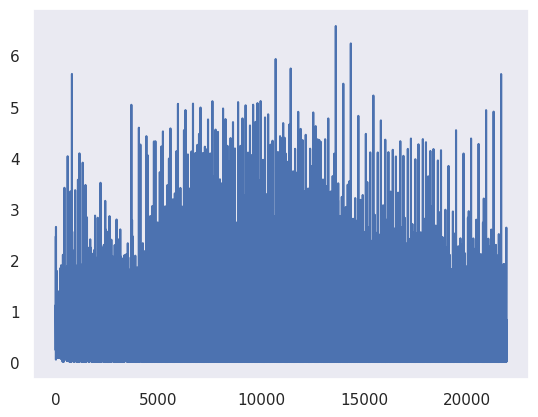

In [19]:
plt.plot(train_losses)

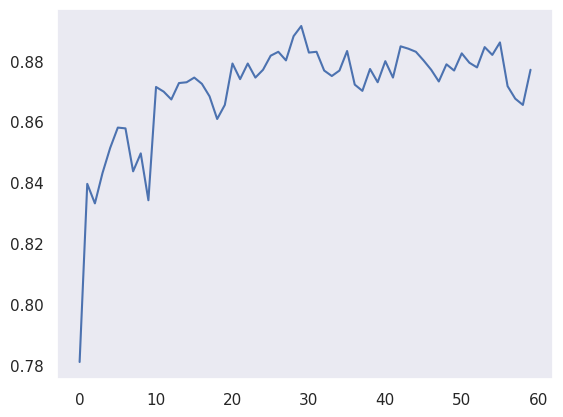

In [20]:
plt.plot(test_accuracy)

In [21]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3410/3872 (0.8807)
{'acc_detail': tensor([0.6266, 0.9621], device='cuda:0'),
 'acc_unweighted': tensor(0.7944, device='cuda:0'),
 'acc_weighted': tensor(0.8807, device='cuda:0'),
 'f1s_detail': tensor([0.7183, 0.9243], device='cuda:0'),
 'f1s_unweighted': tensor(0.8213, device='cuda:0'),
 'f1s_weighted': tensor(0.8743, device='cuda:0'),
 'precision_detail': tensor([0.8414, 0.8893], device='cuda:0'),
 'recall_detail': tensor([0.6266, 0.9621], device='cuda:0'),
 'rocauc': tensor(0.9392, device='cuda:0'),
 'rocauc_detail': tensor([0.9393, 0.9391], device='cuda:0'),
 'uar': tensor(0.7944, device='cuda:0'),
 'wap': tensor(0.8777, device='cuda:0')}


tensor([[ 589,  351],
        [ 111, 2821]], device='cuda:0')

In [22]:
model_dir = '../models_physio16k/'
model_path = f'{model_dir}physio16k_fold2_m13mfcc_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [23]:
checkpoint_path = f'{model_dir}physio16k_fold2_m13mfcc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    # 'best_epoch': best_epoch,
    # 'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)